<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=500 height=300 align=center class="saturate" >

<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

project phase 1
<h4 align="center">Ahmadreza majlesara : 400101861</h4>
<h4 align="center">Amirreza dehghani : 400101197</h4>
</h4>

ّFirst in below block we import neccessery libaries

In [69]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusionmatrix
import torch.nn.functional as F
from collections import Counter
import os


# Q1

We need to import `CIFAR-10` dataset. for this part we write a function to load the data and create a `train_loader` and `test_loader` from that. we use them in future blocks. as we need a `RESNET 18` as our models in training we have to make sure to run the code on GPU.

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def load_and_preprocess_data(batch_size=64):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
    test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=2)

    return train_loader, test_loader

train_loader, test_loader = load_and_preprocess_data()


Files already downloaded and verified

Files already downloaded and verified


In below block we modify the `RESNET 18` model and make it fully connected for our purpose in this project(`SISA algorithm`)

In [72]:
def modify_resnet18(num_classes=10):
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, num_classes)
    )

    model = model.cuda()
    
    return model

model = modify_resnet18()


In below code we train our model on a certain number of epochs and an input model to determine the $w$ of each neuron in our `Resnet 18` model in each shard.

In [73]:
def train_model(model, train_loader, epochs, shardNum , shard, slice):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()
    model.cuda()

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        print(f"Shard [{shardNum}] ,Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
    return model

In this part we learn our `SISA` algorithm. the algorithm is explained in phase 0. overall we divide our train data to $S$ number of shards and divide each Shard to $R$ number of slices and then train a `ResNet 18` model in an isolated envirement(the training of each model is disjointed from othe models)

In [74]:
def sisa_training(train_data, shards, slices, epochs_per_slice):
    shard_size = len(train_data) // shards
    models = []

    for s in range(shards):
        shard_data = torch.utils.data.Subset(train_data, range(s * shard_size, (s + 1) * shard_size))
        shard_loader = DataLoader(shard_data, batch_size=64, shuffle=True, pin_memory=True, num_workers=2)

        slice_size = shard_size // slices
        slice_models = []

        for r in range(slices):
            slice_data = torch.utils.data.Subset(shard_data, range(r * slice_size, (r + 1) * slice_size))
            slice_loader = DataLoader(slice_data, batch_size=64, shuffle=True, pin_memory=True, num_workers=2)

            if r == 0:
                model = modify_resnet18()
                model = train_model(model, slice_loader, epochs_per_slice,s,s,r)
            else:
                model = train_model(model, slice_loader, epochs_per_slice,s,s,r)

            slice_models.append(model)

        models.append(slice_models[-1])

    return models

now we define aggregator function for aggregate the models:

In [75]:
def aggregate_models(models):
    aggregated_model = models[0]
    for model in models[1:]:
        for param, agg_param in zip(model.parameters(), aggregated_model.parameters()):
            agg_param.data.add_(param.data)
    for param in aggregated_model.parameters():
        param.data.div_(len(models))
    
    return aggregated_model.cuda()



And define evaluate function:

In [76]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    auroc = roc_auc_score(y_true, y_scores, multi_class='ovr')

    return f1, accuracy, precision, recall, auroc


now we train and test our model for shards=[5,10,20] and slices=[5,10,20].

In [77]:
shards_list = [5, 10, 20]
slices_list = [5, 10, 20]
epochs_per_slice = 5

for shards in shards_list:
    for slices in slices_list:
        print(f"Training with {shards} shards and {slices} slices...")
        trained_models = sisa_training(train_loader.dataset, shards, slices, epochs_per_slice)
        final_model = aggregate_models(trained_models)

        f1, accuracy, precision, recall, auroc = evaluate_model(final_model.to(device), test_loader)
        print(f"Results for shards={shards}, slices={slices}:")
        print(f"F1 Score: {f1}")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"AUROC: {auroc}")
        print("-" * 50)

Training with 5 shards and 5 slices...

Shard [0] ,Epoch [1/5], Loss: 1.8378, Accuracy: 33.85%

Shard [0] ,Epoch [2/5], Loss: 1.3231, Accuracy: 54.85%

Shard [0] ,Epoch [3/5], Loss: 1.0836, Accuracy: 63.30%

Shard [0] ,Epoch [4/5], Loss: 0.9025, Accuracy: 71.20%

Shard [0] ,Epoch [5/5], Loss: 0.8250, Accuracy: 74.90%

Shard [0] ,Epoch [1/5], Loss: 1.3311, Accuracy: 57.05%

Shard [0] ,Epoch [2/5], Loss: 0.9661, Accuracy: 71.15%

Shard [0] ,Epoch [3/5], Loss: 0.7972, Accuracy: 76.00%

Shard [0] ,Epoch [4/5], Loss: 0.6975, Accuracy: 80.35%

Shard [0] ,Epoch [5/5], Loss: 0.5157, Accuracy: 85.55%

Shard [0] ,Epoch [1/5], Loss: 1.2539, Accuracy: 62.05%

Shard [0] ,Epoch [2/5], Loss: 0.9497, Accuracy: 70.20%

Shard [0] ,Epoch [3/5], Loss: 0.7273, Accuracy: 77.10%

Shard [0] ,Epoch [4/5], Loss: 0.5742, Accuracy: 82.65%

Shard [0] ,Epoch [5/5], Loss: 0.4796, Accuracy: 86.60%

Shard [0] ,Epoch [1/5], Loss: 1.1598, Accuracy: 64.90%

Shard [0] ,Epoch [2/5], Loss: 0.7960, Accuracy: 75.85%

Shard [0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Results for shards=5, slices=5:

F1 Score: 0.01818181818181818

Accuracy: 0.1

Precision: 0.01

Recall: 0.1

AUROC: 0.6353743277777777

--------------------------------------------------

Training with 5 shards and 10 slices...

Shard [0] ,Epoch [1/5], Loss: 2.1030, Accuracy: 22.70%

Shard [0] ,Epoch [2/5], Loss: 1.4838, Accuracy: 48.60%

Shard [0] ,Epoch [3/5], Loss: 1.0743, Accuracy: 66.40%

Shard [0] ,Epoch [4/5], Loss: 0.8579, Accuracy: 73.70%

Shard [0] ,Epoch [5/5], Loss: 0.6984, Accuracy: 78.60%

Shard [0] ,Epoch [1/5], Loss: 1.5172, Accuracy: 51.50%

Shard [0] ,Epoch [2/5], Loss: 1.1213, Accuracy: 62.10%

Shard [0] ,Epoch [3/5], Loss: 0.8280, Accuracy: 73.40%

Shard [0] ,Epoch [4/5], Loss: 0.6836, Accuracy: 79.10%

Shard [0] ,Epoch [5/5], Loss: 0.6069, Accuracy: 84.10%

Shard [0] ,Epoch [1/5], Loss: 1.4380, Accuracy: 55.00%

Shard [0] ,Epoch [2/5], Loss: 0.9828, Accuracy: 71.00%

Shard [0] ,Epoch [3/5], Loss: 0.7537, Accuracy: 76.90%

Shard [0] ,Epoch [4/5], Loss: 0.5713, Accur

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Results for shards=5, slices=10:

F1 Score: 0.01818181818181818

Accuracy: 0.1

Precision: 0.01

Recall: 0.1

AUROC: 0.5268147555555556

--------------------------------------------------

Training with 5 shards and 20 slices...

Shard [0] ,Epoch [1/5], Loss: 2.2322, Accuracy: 14.40%

Shard [0] ,Epoch [2/5], Loss: 1.6988, Accuracy: 48.60%

Shard [0] ,Epoch [3/5], Loss: 1.0108, Accuracy: 65.80%

Shard [0] ,Epoch [4/5], Loss: 0.7136, Accuracy: 77.00%

Shard [0] ,Epoch [5/5], Loss: 0.5950, Accuracy: 81.60%

Shard [0] ,Epoch [1/5], Loss: 1.8975, Accuracy: 44.80%

Shard [0] ,Epoch [2/5], Loss: 1.3060, Accuracy: 57.60%

Shard [0] ,Epoch [3/5], Loss: 0.8180, Accuracy: 72.20%

Shard [0] ,Epoch [4/5], Loss: 0.5680, Accuracy: 79.20%

Shard [0] ,Epoch [5/5], Loss: 0.5233, Accuracy: 83.40%

Shard [0] ,Epoch [1/5], Loss: 1.8097, Accuracy: 46.60%

Shard [0] ,Epoch [2/5], Loss: 1.4046, Accuracy: 61.40%

Shard [0] ,Epoch [3/5], Loss: 0.9766, Accuracy: 68.80%

Shard [0] ,Epoch [4/5], Loss: 0.7016, Accu

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Results for shards=5, slices=20:

F1 Score: 0.01818181818181818

Accuracy: 0.1

Precision: 0.01

Recall: 0.1

AUROC: 0.4999777777777778

--------------------------------------------------

Training with 10 shards and 5 slices...

Shard [0] ,Epoch [1/5], Loss: 2.1275, Accuracy: 22.60%

Shard [0] ,Epoch [2/5], Loss: 1.4364, Accuracy: 45.80%

Shard [0] ,Epoch [3/5], Loss: 1.0775, Accuracy: 62.40%

Shard [0] ,Epoch [4/5], Loss: 0.8265, Accuracy: 72.50%

Shard [0] ,Epoch [5/5], Loss: 0.7329, Accuracy: 77.10%

Shard [0] ,Epoch [1/5], Loss: 1.5619, Accuracy: 45.70%

Shard [0] ,Epoch [2/5], Loss: 1.1127, Accuracy: 65.60%

Shard [0] ,Epoch [3/5], Loss: 0.7767, Accuracy: 75.90%

Shard [0] ,Epoch [4/5], Loss: 0.6612, Accuracy: 78.80%

Shard [0] ,Epoch [5/5], Loss: 0.5222, Accuracy: 85.30%

Shard [0] ,Epoch [1/5], Loss: 1.4647, Accuracy: 54.50%

Shard [0] ,Epoch [2/5], Loss: 0.9695, Accuracy: 68.40%

Shard [0] ,Epoch [3/5], Loss: 0.8112, Accuracy: 76.30%

Shard [0] ,Epoch [4/5], Loss: 0.7224, Accu

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Results for shards=10, slices=5:

F1 Score: 0.01818181818181818

Accuracy: 0.1

Precision: 0.01

Recall: 0.1

AUROC: 0.6481585222222221

--------------------------------------------------

Training with 10 shards and 10 slices...

Shard [0] ,Epoch [1/5], Loss: 2.2297, Accuracy: 15.20%

Shard [0] ,Epoch [2/5], Loss: 1.6959, Accuracy: 42.00%

Shard [0] ,Epoch [3/5], Loss: 1.1767, Accuracy: 58.60%

Shard [0] ,Epoch [4/5], Loss: 0.8455, Accuracy: 71.40%

Shard [0] ,Epoch [5/5], Loss: 0.5931, Accuracy: 80.40%

Shard [0] ,Epoch [1/5], Loss: 1.9123, Accuracy: 43.80%

Shard [0] ,Epoch [2/5], Loss: 1.3842, Accuracy: 55.80%

Shard [0] ,Epoch [3/5], Loss: 0.8758, Accuracy: 71.40%

Shard [0] ,Epoch [4/5], Loss: 0.7149, Accuracy: 77.00%

Shard [0] ,Epoch [5/5], Loss: 0.6255, Accuracy: 82.00%

Shard [0] ,Epoch [1/5], Loss: 1.6698, Accuracy: 51.20%

Shard [0] ,Epoch [2/5], Loss: 1.3089, Accuracy: 59.20%

Shard [0] ,Epoch [3/5], Loss: 1.0812, Accuracy: 66.60%

Shard [0] ,Epoch [4/5], Loss: 0.7271, Acc

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Results for shards=10, slices=10:

F1 Score: 0.01818181818181818

Accuracy: 0.1

Precision: 0.01

Recall: 0.1

AUROC: 0.5

--------------------------------------------------

Training with 10 shards and 20 slices...

Shard [0] ,Epoch [1/5], Loss: 2.2960, Accuracy: 11.60%

Shard [0] ,Epoch [2/5], Loss: 2.0328, Accuracy: 34.00%

Shard [0] ,Epoch [3/5], Loss: 1.5685, Accuracy: 47.20%

Shard [0] ,Epoch [4/5], Loss: 0.9405, Accuracy: 70.00%

Shard [0] ,Epoch [5/5], Loss: 0.4891, Accuracy: 88.00%

Shard [0] ,Epoch [1/5], Loss: 2.3251, Accuracy: 43.20%

Shard [0] ,Epoch [2/5], Loss: 1.2172, Accuracy: 57.20%

Shard [0] ,Epoch [3/5], Loss: 0.9971, Accuracy: 71.60%

Shard [0] ,Epoch [4/5], Loss: 0.6941, Accuracy: 77.20%

Shard [0] ,Epoch [5/5], Loss: 0.4396, Accuracy: 86.40%

Shard [0] ,Epoch [1/5], Loss: 2.1597, Accuracy: 40.40%

Shard [0] ,Epoch [2/5], Loss: 1.5133, Accuracy: 56.80%

Shard [0] ,Epoch [3/5], Loss: 1.2266, Accuracy: 66.80%

Shard [0] ,Epoch [4/5], Loss: 0.8942, Accuracy: 73.60%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Results for shards=10, slices=20:

F1 Score: 0.01818181818181818

Accuracy: 0.1

Precision: 0.01

Recall: 0.1

AUROC: 0.5

--------------------------------------------------

Training with 20 shards and 5 slices...

Shard [0] ,Epoch [1/5], Loss: 2.2010, Accuracy: 21.80%

Shard [0] ,Epoch [2/5], Loss: 1.5763, Accuracy: 46.20%

Shard [0] ,Epoch [3/5], Loss: 1.0410, Accuracy: 63.80%

Shard [0] ,Epoch [4/5], Loss: 0.8095, Accuracy: 73.80%

Shard [0] ,Epoch [5/5], Loss: 0.7293, Accuracy: 77.80%

Shard [0] ,Epoch [1/5], Loss: 1.8046, Accuracy: 44.20%

Shard [0] ,Epoch [2/5], Loss: 1.2998, Accuracy: 57.00%

Shard [0] ,Epoch [3/5], Loss: 0.8280, Accuracy: 72.60%

Shard [0] ,Epoch [4/5], Loss: 0.5340, Accuracy: 81.40%

Shard [0] ,Epoch [5/5], Loss: 0.5674, Accuracy: 83.60%

Shard [0] ,Epoch [1/5], Loss: 1.7299, Accuracy: 45.80%

Shard [0] ,Epoch [2/5], Loss: 1.4060, Accuracy: 53.00%

Shard [0] ,Epoch [3/5], Loss: 1.0444, Accuracy: 65.20%

Shard [0] ,Epoch [4/5], Loss: 0.6865, Accuracy: 76.60%



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Results for shards=20, slices=5:

F1 Score: 0.01818181818181818

Accuracy: 0.1

Precision: 0.01

Recall: 0.1

AUROC: 0.4966437833333333

--------------------------------------------------

Training with 20 shards and 10 slices...

Shard [0] ,Epoch [1/5], Loss: 2.2860, Accuracy: 11.60%

Shard [0] ,Epoch [2/5], Loss: 2.0267, Accuracy: 29.60%

Shard [0] ,Epoch [3/5], Loss: 1.5852, Accuracy: 46.00%

Shard [0] ,Epoch [4/5], Loss: 1.1192, Accuracy: 62.80%

Shard [0] ,Epoch [5/5], Loss: 0.7166, Accuracy: 81.20%

Shard [0] ,Epoch [1/5], Loss: 2.2967, Accuracy: 38.00%

Shard [0] ,Epoch [2/5], Loss: 1.2512, Accuracy: 67.60%

Shard [0] ,Epoch [3/5], Loss: 0.9804, Accuracy: 74.40%

Shard [0] ,Epoch [4/5], Loss: 0.6574, Accuracy: 79.20%

Shard [0] ,Epoch [5/5], Loss: 0.4296, Accuracy: 88.40%

Shard [0] ,Epoch [1/5], Loss: 2.0600, Accuracy: 40.40%

Shard [0] ,Epoch [2/5], Loss: 1.3882, Accuracy: 59.20%

Shard [0] ,Epoch [3/5], Loss: 1.1245, Accuracy: 64.40%

Shard [0] ,Epoch [4/5], Loss: 0.8613, Acc

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Results for shards=20, slices=10:

F1 Score: 0.01818181818181818

Accuracy: 0.1

Precision: 0.01

Recall: 0.1

AUROC: 0.5

--------------------------------------------------

Training with 20 shards and 20 slices...

Shard [0] ,Epoch [1/5], Loss: 2.2972, Accuracy: 15.20%

Shard [0] ,Epoch [2/5], Loss: 2.0964, Accuracy: 15.20%

Shard [0] ,Epoch [3/5], Loss: 1.7824, Accuracy: 24.00%

Shard [0] ,Epoch [4/5], Loss: 1.4998, Accuracy: 51.20%

Shard [0] ,Epoch [5/5], Loss: 1.1480, Accuracy: 60.80%

Shard [0] ,Epoch [1/5], Loss: 2.3855, Accuracy: 30.40%

Shard [0] ,Epoch [2/5], Loss: 1.9130, Accuracy: 51.20%

Shard [0] ,Epoch [3/5], Loss: 1.4275, Accuracy: 63.20%

Shard [0] ,Epoch [4/5], Loss: 1.1542, Accuracy: 64.80%

Shard [0] ,Epoch [5/5], Loss: 0.9060, Accuracy: 71.20%

Shard [0] ,Epoch [1/5], Loss: 1.9220, Accuracy: 38.40%

Shard [0] ,Epoch [2/5], Loss: 1.4144, Accuracy: 53.60%

Shard [0] ,Epoch [3/5], Loss: 0.9801, Accuracy: 66.40%

Shard [0] ,Epoch [4/5], Loss: 0.6862, Accuracy: 80.00%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


The above code and evaluate our code with averaging as our aggregation method. now we use majority voting as our aggregation method and do the prevous part again:

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
from collections import Counter
import matplotlib.pyplot as plt
import os
import random

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs('saved_models', exist_ok=True)

def load_and_preprocess_data(batch_size=64):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
    test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [10]:
def modify_resnet18(num_classes=10):
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, num_classes)
    )
    model.out_features = num_classes
    return model.to(device)

In [11]:
def train_model(model, train_loader, epochs, shard, slice):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    model.to(device)
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            if images.size(0) == 1:
                print(f"Skipping batch with size 1 in shard {shard}, slice {slice}")
                continue
            
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
    
    model_path = f'saved_models/model_shard_{shard}_slice_{slice}.pth'
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")
    
    return model

In [12]:
def sisa_training(train_data, shards, slices, epochs_per_slice):
    shard_size = len(train_data) // shards
    models = []
    
    for s in range(shards):
        shard_data = torch.utils.data.Subset(train_data, range(s * shard_size, (s + 1) * shard_size))
        shard_loader = DataLoader(shard_data, batch_size=64, shuffle=True)
        
        slice_size = shard_size // slices
        slice_models = []
        
        for r in range(slices):
            slice_data = torch.utils.data.Subset(shard_data, range(r * slice_size, (r + 1) * slice_size))
            slice_loader = DataLoader(slice_data, batch_size=64, shuffle=True)
            
            if r == 0:
                model = modify_resnet18()
                model = train_model(model, slice_loader, epochs_per_slice, s, r)
            else:
                model = train_model(model, slice_loader, epochs_per_slice, s, r)
                
            slice_models.append(model)
        
        models.append(slice_models[-1])
    
    return models

In [13]:
def aggregate_predictions(models, dataloader):
    models = [model.to(device) for model in models]
    y_true = []
    y_pred_all = [[] for _ in models]
    y_softmax_all = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            y_true.extend(labels.cpu().numpy())
            
            outputs_sum = torch.zeros((inputs.size(0), models[0].out_features)).to(device)
            
            for idx, model in enumerate(models):
                model.eval()
                outputs = model(inputs)
                outputs_sum += F.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)
                y_pred_all[idx].extend(predicted.cpu().numpy())
            
            y_softmax_all.append(outputs_sum / len(models))

    y_pred_final = []
    for preds in zip(*y_pred_all):
        most_common = Counter(preds).most_common(1)[0][0]
        y_pred_final.append(most_common)
    
    y_softmax_all = torch.cat(y_softmax_all)
    
    return y_true, y_pred_final, y_softmax_all

In [14]:
def evaluate_model(models, test_loader):
    y_true, y_pred, y_softmax_all = aggregate_predictions(models, test_loader)
    
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    auroc = roc_auc_score(y_true, y_softmax_all.cpu(), multi_class='ovr')
    
    cr = classification_report(y_true, y_pred)
    
    print("Classification Report:\n", cr)
    
    return f1, accuracy, precision, recall, auroc

In [8]:
train_loader, test_loader = load_and_preprocess_data()
shards_list = [5, 10, 20]
slices_list = [5, 10, 20]
epochs_per_slice = 5  
trainACC = []
for shards in shards_list:
    for slices in slices_list:
        print(f"Training with {shards} shards and {slices} slices...")
        trained_models = sisa_training(train_loader.dataset, shards, slices, epochs_per_slice)
        
        f1, accuracy, precision, recall, auroc = evaluate_model(trained_models, test_loader)
        trainACC.append(accuracy)
        print(f"Results for shards={shards}, slices={slices}:")
        print(f"F1 Score: {f1}")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"AUROC: {auroc}")
        print("-" * 50)


100%|██████████| 170498071/170498071 [00:05<00:00, 29572447.22it/s]


Extracting data/cifar-10-python.tar.gz to data

Files already downloaded and verified

Training with 5 shards and 5 slices...


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth

100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s] 


Epoch [1/5], Loss: 1.8289, Accuracy: 34.35%

Epoch [2/5], Loss: 1.3439, Accuracy: 53.15%

Epoch [3/5], Loss: 1.0913, Accuracy: 62.95%

Epoch [4/5], Loss: 0.8611, Accuracy: 71.60%

Epoch [5/5], Loss: 0.7806, Accuracy: 76.10%

Model saved to saved_models/model_shard_0_slice_0.pth

Epoch [1/5], Loss: 1.3999, Accuracy: 57.30%

Epoch [2/5], Loss: 1.0137, Accuracy: 69.15%

Epoch [3/5], Loss: 0.8417, Accuracy: 75.65%

Epoch [4/5], Loss: 0.7281, Accuracy: 78.90%

Epoch [5/5], Loss: 0.6772, Accuracy: 81.25%

Model saved to saved_models/model_shard_0_slice_1.pth

Epoch [1/5], Loss: 1.2308, Accuracy: 61.90%

Epoch [2/5], Loss: 0.9216, Accuracy: 72.40%

Epoch [3/5], Loss: 0.7174, Accuracy: 78.95%

Epoch [4/5], Loss: 0.6501, Accuracy: 81.90%

Epoch [5/5], Loss: 0.6082, Accuracy: 81.95%

Model saved to saved_models/model_shard_0_slice_2.pth

Epoch [1/5], Loss: 1.1817, Accuracy: 63.65%

Epoch [2/5], Loss: 0.7805, Accuracy: 76.85%

Epoch [3/5], Loss: 0.5778, Accuracy: 83.60%

Epoch [4/5], Loss: 0.4995

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 2.1161, Accuracy: 21.00%

Epoch [2/5], Loss: 1.6083, Accuracy: 39.50%

Epoch [3/5], Loss: 1.2956, Accuracy: 48.10%

Epoch [4/5], Loss: 1.1220, Accuracy: 55.20%

Epoch [5/5], Loss: 1.0455, Accuracy: 59.70%

Model saved to saved_models/model_shard_0_slice_0.pth

Epoch [1/5], Loss: 1.6133, Accuracy: 43.60%

Epoch [2/5], Loss: 1.1939, Accuracy: 58.50%

Epoch [3/5], Loss: 0.8682, Accuracy: 69.00%

Epoch [4/5], Loss: 0.7079, Accuracy: 76.80%

Epoch [5/5], Loss: 0.7957, Accuracy: 77.30%

Model saved to saved_models/model_shard_0_slice_1.pth

Epoch [1/5], Loss: 1.4395, Accuracy: 54.20%

Epoch [2/5], Loss: 1.1692, Accuracy: 61.60%

Epoch [3/5], Loss: 0.7799, Accuracy: 74.50%

Epoch [4/5], Loss: 0.7083, Accuracy: 78.20%

Epoch [5/5], Loss: 0.6456, Accuracy: 80.60%

Model saved to saved_models/model_shard_0_slice_2.pth

Epoch [1/5], Loss: 1.5265, Accuracy: 54.00%

Epoch [2/5], Loss: 1.0357, Accuracy: 68.40%

Epoch [3/5], Loss: 0.7531, Accuracy: 76.30%

Epoch [4/5], Loss: 0.6121

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 2.2369, Accuracy: 16.20%

Epoch [2/5], Loss: 1.6797, Accuracy: 42.60%

Epoch [3/5], Loss: 1.2746, Accuracy: 57.00%

Epoch [4/5], Loss: 0.8508, Accuracy: 71.20%

Epoch [5/5], Loss: 0.6120, Accuracy: 81.60%

Model saved to saved_models/model_shard_0_slice_0.pth

Epoch [1/5], Loss: 1.6676, Accuracy: 48.80%

Epoch [2/5], Loss: 1.2772, Accuracy: 59.20%

Epoch [3/5], Loss: 0.7492, Accuracy: 75.00%

Epoch [4/5], Loss: 0.5415, Accuracy: 82.60%

Epoch [5/5], Loss: 0.4926, Accuracy: 84.20%

Model saved to saved_models/model_shard_0_slice_1.pth

Epoch [1/5], Loss: 1.8639, Accuracy: 43.60%

Epoch [2/5], Loss: 1.4118, Accuracy: 54.00%

Epoch [3/5], Loss: 1.0084, Accuracy: 64.40%

Epoch [4/5], Loss: 0.7122, Accuracy: 73.40%

Epoch [5/5], Loss: 0.5753, Accuracy: 80.40%

Model saved to saved_models/model_shard_0_slice_2.pth

Epoch [1/5], Loss: 1.7470, Accuracy: 49.00%

Epoch [2/5], Loss: 1.2445, Accuracy: 62.00%

Epoch [3/5], Loss: 0.8547, Accuracy: 71.00%

Epoch [4/5], Loss: 0.7026

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 2.0682, Accuracy: 23.40%

Epoch [2/5], Loss: 1.3721, Accuracy: 53.50%

Epoch [3/5], Loss: 1.1917, Accuracy: 60.00%

Epoch [4/5], Loss: 0.9000, Accuracy: 69.40%

Epoch [5/5], Loss: 0.7044, Accuracy: 77.10%

Model saved to saved_models/model_shard_0_slice_0.pth

Epoch [1/5], Loss: 1.4992, Accuracy: 51.40%

Epoch [2/5], Loss: 0.9857, Accuracy: 68.70%

Epoch [3/5], Loss: 0.7709, Accuracy: 76.80%

Epoch [4/5], Loss: 0.5627, Accuracy: 83.60%

Epoch [5/5], Loss: 0.5871, Accuracy: 83.30%

Model saved to saved_models/model_shard_0_slice_1.pth

Epoch [1/5], Loss: 1.4050, Accuracy: 56.90%

Epoch [2/5], Loss: 1.0070, Accuracy: 65.90%

Epoch [3/5], Loss: 0.8175, Accuracy: 74.30%

Epoch [4/5], Loss: 0.6150, Accuracy: 81.20%

Epoch [5/5], Loss: 0.4946, Accuracy: 85.70%

Model saved to saved_models/model_shard_0_slice_2.pth

Epoch [1/5], Loss: 1.5510, Accuracy: 53.90%

Epoch [2/5], Loss: 1.1098, Accuracy: 67.20%

Epoch [3/5], Loss: 0.8365, Accuracy: 74.30%

Epoch [4/5], Loss: 0.6904

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 2.2109, Accuracy: 19.20%

Epoch [2/5], Loss: 1.7231, Accuracy: 42.40%

Epoch [3/5], Loss: 1.2401, Accuracy: 60.60%

Epoch [4/5], Loss: 0.9248, Accuracy: 65.00%

Epoch [5/5], Loss: 0.8985, Accuracy: 75.40%

Model saved to saved_models/model_shard_0_slice_0.pth

Epoch [1/5], Loss: 1.8680, Accuracy: 39.20%

Epoch [2/5], Loss: 1.4286, Accuracy: 48.40%

Epoch [3/5], Loss: 0.9619, Accuracy: 64.20%

Epoch [4/5], Loss: 0.7491, Accuracy: 73.00%

Epoch [5/5], Loss: 0.6884, Accuracy: 77.60%

Model saved to saved_models/model_shard_0_slice_1.pth

Epoch [1/5], Loss: 1.8706, Accuracy: 42.00%

Epoch [2/5], Loss: 1.4268, Accuracy: 55.20%

Epoch [3/5], Loss: 0.9851, Accuracy: 65.20%

Epoch [4/5], Loss: 0.7368, Accuracy: 76.80%

Epoch [5/5], Loss: 0.5848, Accuracy: 82.00%

Model saved to saved_models/model_shard_0_slice_2.pth

Epoch [1/5], Loss: 1.7765, Accuracy: 47.00%

Epoch [2/5], Loss: 1.3526, Accuracy: 56.20%

Epoch [3/5], Loss: 0.9186, Accuracy: 68.60%

Epoch [4/5], Loss: 0.6777

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 2.3017, Accuracy: 12.00%

Epoch [2/5], Loss: 2.0957, Accuracy: 23.20%

Epoch [3/5], Loss: 1.6467, Accuracy: 43.60%

Epoch [4/5], Loss: 1.0501, Accuracy: 70.00%

Epoch [5/5], Loss: 0.5636, Accuracy: 84.00%

Model saved to saved_models/model_shard_0_slice_0.pth

Epoch [1/5], Loss: 2.3661, Accuracy: 33.60%

Epoch [2/5], Loss: 1.2869, Accuracy: 56.00%

Epoch [3/5], Loss: 1.1340, Accuracy: 68.00%

Epoch [4/5], Loss: 0.7174, Accuracy: 85.20%

Epoch [5/5], Loss: 0.4133, Accuracy: 92.40%

Model saved to saved_models/model_shard_0_slice_1.pth

Epoch [1/5], Loss: 1.9531, Accuracy: 48.00%

Epoch [2/5], Loss: 1.3538, Accuracy: 64.40%

Epoch [3/5], Loss: 1.0509, Accuracy: 71.20%

Epoch [4/5], Loss: 0.6963, Accuracy: 77.60%

Epoch [5/5], Loss: 0.4915, Accuracy: 82.40%

Model saved to saved_models/model_shard_0_slice_2.pth

Epoch [1/5], Loss: 2.0761, Accuracy: 44.80%

Epoch [2/5], Loss: 1.3364, Accuracy: 57.20%

Epoch [3/5], Loss: 1.1635, Accuracy: 60.00%

Epoch [4/5], Loss: 0.8587

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 2.2212, Accuracy: 20.00%

Epoch [2/5], Loss: 1.6784, Accuracy: 40.20%

Epoch [3/5], Loss: 1.0305, Accuracy: 64.00%

Epoch [4/5], Loss: 0.6705, Accuracy: 79.20%

Epoch [5/5], Loss: 0.5953, Accuracy: 83.00%

Model saved to saved_models/model_shard_0_slice_0.pth

Epoch [1/5], Loss: 1.8399, Accuracy: 44.60%

Epoch [2/5], Loss: 1.3843, Accuracy: 56.80%

Epoch [3/5], Loss: 0.9160, Accuracy: 71.00%

Epoch [4/5], Loss: 0.7355, Accuracy: 77.20%

Epoch [5/5], Loss: 0.5065, Accuracy: 83.40%

Model saved to saved_models/model_shard_0_slice_1.pth

Epoch [1/5], Loss: 1.7368, Accuracy: 49.20%

Epoch [2/5], Loss: 1.3350, Accuracy: 61.20%

Epoch [3/5], Loss: 0.8489, Accuracy: 72.00%

Epoch [4/5], Loss: 0.5663, Accuracy: 81.20%

Epoch [5/5], Loss: 0.6132, Accuracy: 80.40%

Model saved to saved_models/model_shard_0_slice_2.pth

Epoch [1/5], Loss: 1.5380, Accuracy: 52.00%

Epoch [2/5], Loss: 1.1173, Accuracy: 65.60%

Epoch [3/5], Loss: 0.8299, Accuracy: 73.20%

Epoch [4/5], Loss: 0.6173

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 2.2783, Accuracy: 14.00%

Epoch [2/5], Loss: 2.0036, Accuracy: 24.80%

Epoch [3/5], Loss: 1.5878, Accuracy: 48.40%

Epoch [4/5], Loss: 1.1205, Accuracy: 56.80%

Epoch [5/5], Loss: 0.7633, Accuracy: 72.00%

Model saved to saved_models/model_shard_0_slice_0.pth

Epoch [1/5], Loss: 2.2724, Accuracy: 36.80%

Epoch [2/5], Loss: 1.3480, Accuracy: 50.80%

Epoch [3/5], Loss: 1.0574, Accuracy: 64.40%

Epoch [4/5], Loss: 0.7359, Accuracy: 72.00%

Epoch [5/5], Loss: 0.5327, Accuracy: 80.40%

Model saved to saved_models/model_shard_0_slice_1.pth

Epoch [1/5], Loss: 2.0134, Accuracy: 40.00%

Epoch [2/5], Loss: 1.4235, Accuracy: 56.80%

Epoch [3/5], Loss: 1.2543, Accuracy: 61.20%

Epoch [4/5], Loss: 0.8855, Accuracy: 70.80%

Epoch [5/5], Loss: 0.5827, Accuracy: 83.20%

Model saved to saved_models/model_shard_0_slice_2.pth

Epoch [1/5], Loss: 2.0713, Accuracy: 40.00%

Epoch [2/5], Loss: 1.4272, Accuracy: 52.80%

Epoch [3/5], Loss: 1.1846, Accuracy: 66.00%

Epoch [4/5], Loss: 0.8600

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 2.3033, Accuracy: 5.60%

Epoch [2/5], Loss: 2.1464, Accuracy: 32.00%

Epoch [3/5], Loss: 1.7724, Accuracy: 43.20%

Epoch [4/5], Loss: 1.3669, Accuracy: 60.80%

Epoch [5/5], Loss: 1.1262, Accuracy: 60.00%

Model saved to saved_models/model_shard_0_slice_0.pth

Epoch [1/5], Loss: 2.5703, Accuracy: 24.80%

Epoch [2/5], Loss: 1.4311, Accuracy: 66.40%

Epoch [3/5], Loss: 1.2470, Accuracy: 78.40%

Epoch [4/5], Loss: 0.9544, Accuracy: 80.00%

Epoch [5/5], Loss: 0.6330, Accuracy: 84.00%

Model saved to saved_models/model_shard_0_slice_1.pth

Epoch [1/5], Loss: 2.0512, Accuracy: 36.80%

Epoch [2/5], Loss: 1.1705, Accuracy: 62.40%

Epoch [3/5], Loss: 0.9304, Accuracy: 78.40%

Epoch [4/5], Loss: 0.5636, Accuracy: 91.20%

Epoch [5/5], Loss: 0.3452, Accuracy: 92.00%

Model saved to saved_models/model_shard_0_slice_2.pth

Epoch [1/5], Loss: 1.9724, Accuracy: 46.40%

Epoch [2/5], Loss: 1.1339, Accuracy: 66.40%

Epoch [3/5], Loss: 0.9042, Accuracy: 75.20%

Epoch [4/5], Loss: 0.6329,

As we can see when the number of the shards or slices increase the accuracy and other evaluate parameters decrease.When the number of shards increase we have the smaller train set and when the number of the slices increase we have the weak learner problem. also we can clearly see that using majority voting as aggregation method is much better in term of accuracy. (the essay suggests this too)

# Q2

In this part we write the code for unlearning. this code simply find the shards and slices that we want to unlearn, find them and retrain their models without those slices and aggregate that in the last.

In [6]:
from torch.utils.data import DataLoader, Subset

def unlearn_data(train_loader, trained_models, forget_indices, shards, slices, epochs_per_slice):
    shard_size = len(train_loader.dataset) // shards
    updated_models = trained_models.copy()

    forget_shard_slice = []
    for idx in forget_indices:
        shard_id = idx // shard_size
        slice_id = (idx % shard_size) // (shard_size // slices)
        forget_shard_slice.append((shard_id, slice_id))
        
    for shard_id, slice_id in set(forget_shard_slice):
        shard_indices = list(range(shard_id * shard_size, (shard_id + 1) * shard_size))
        updated_shard_indices = [i for i in shard_indices if i not in forget_indices]
        updated_shard_data = Subset(train_loader.dataset, updated_shard_indices)
        shard_loader = DataLoader(updated_shard_data, batch_size=64, shuffle=True)
        slice_size = shard_size // slices
        slice_indices = list(range(slice_id * slice_size, (slice_id + 1) * slice_size))
        updated_slice_indices = [i for i in slice_indices if i + shard_id * shard_size not in forget_indices]
        updated_slice_data = Subset(train_loader.dataset, updated_slice_indices)
        slice_loader = DataLoader(updated_slice_data, batch_size=64, shuffle=True)
        model = modify_resnet18()
        model.load_state_dict(torch.load(f'saved_models/model_shard_{shard_id}_slice_{slice_id}.pth'))
        updated_model = train_model(model, slice_loader, epochs_per_slice, shard_id, slice_id)
        updated_models[shard_id] = updated_model

    return updated_models


And we define this function for trainnig and unlearning the model with getting shards and slices.

In [7]:
def trainAndUnleran(shards, slices):
    train_loader, test_loader = load_and_preprocess_data()
    epochs_per_slice = 5

    print(f"Training with {shards} shards and {slices} slices...")
    trained_models = sisa_training(train_loader.dataset, shards, slices, epochs_per_slice)

    f1, accuracy, precision, recall, auroc = evaluate_model(trained_models, test_loader)
    print(f"Initial Results for shards={shards}, slices={slices}:")
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}") 
    print(f"Recall: {recall}")
    print(f"AUROC: {auroc}")
    print("-" * 50)
    trainAccuracy = accuracy
    forget_indices = random.sample(range(len(train_loader.dataset)), 500)

    updated_models = unlearn_data(train_loader, trained_models, forget_indices, shards, slices, epochs_per_slice)

    f1, accuracy, precision, recall, auroc = evaluate_model(updated_models, test_loader)
    print(f"Updated Results after Unlearning for shards={shards}, slices={slices}:")
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"AUROC: {auroc}")
    print("-" * 50)
    unlearnAccuracy=accuracy
    
    return trainAccuracy, unlearnAccuracy

And finally we run the above function for shards = [5,10,20] and slices = [5,10,20]

In [19]:
shards = [5,10,20]
slices = [5,10,20]
tranACCS=[]
unlearnACCs=[]
for shard in shards:
    for slici in slices:
        trainACC,unlearnACC = trainAndUnleran(shard,slici)
        tranACCS.append(trainACC)
        unlearnACCs.append(unlearnACC)

100%|██████████| 170498071/170498071 [00:03<00:00, 48446635.70it/s]


Extracting data/cifar-10-python.tar.gz to data

Files already downloaded and verified

Training with 5 shards and 5 slices...


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth

100%|██████████| 44.7M/44.7M [00:00<00:00, 77.4MB/s]


Epoch [1/5], Loss: 1.8420, Accuracy: 35.25%

Epoch [2/5], Loss: 1.2970, Accuracy: 55.90%

Epoch [3/5], Loss: 1.0849, Accuracy: 65.05%

Epoch [4/5], Loss: 0.8478, Accuracy: 72.30%

Epoch [5/5], Loss: 0.7984, Accuracy: 76.15%

Model saved to saved_models/model_shard_0_slice_0.pth

Epoch [1/5], Loss: 1.3824, Accuracy: 56.00%

Epoch [2/5], Loss: 0.9940, Accuracy: 70.55%

Epoch [3/5], Loss: 0.9929, Accuracy: 70.25%

Epoch [4/5], Loss: 0.7279, Accuracy: 78.90%

Epoch [5/5], Loss: 0.5938, Accuracy: 83.70%

Model saved to saved_models/model_shard_0_slice_1.pth

Epoch [1/5], Loss: 1.2881, Accuracy: 58.20%

Epoch [2/5], Loss: 0.8962, Accuracy: 72.85%

Epoch [3/5], Loss: 0.7069, Accuracy: 79.90%

Epoch [4/5], Loss: 0.6141, Accuracy: 82.70%

Epoch [5/5], Loss: 0.5017, Accuracy: 85.70%

Model saved to saved_models/model_shard_0_slice_2.pth

Epoch [1/5], Loss: 1.1650, Accuracy: 64.00%

Epoch [2/5], Loss: 0.8232, Accuracy: 75.75%

Epoch [3/5], Loss: 0.6128, Accuracy: 82.00%

Epoch [4/5], Loss: 0.4948

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 1.3181, Accuracy: 57.19%

Epoch [2/5], Loss: 1.0080, Accuracy: 67.04%

Epoch [3/5], Loss: 0.7292, Accuracy: 78.29%

Epoch [4/5], Loss: 0.6155, Accuracy: 81.93%

Epoch [5/5], Loss: 0.5551, Accuracy: 83.75%

Model saved to saved_models/model_shard_4_slice_0.pth

Epoch [1/5], Loss: 1.1626, Accuracy: 64.69%

Epoch [2/5], Loss: 0.7402, Accuracy: 76.78%

Epoch [3/5], Loss: 0.5018, Accuracy: 85.03%

Epoch [4/5], Loss: 0.3675, Accuracy: 88.82%

Epoch [5/5], Loss: 0.2713, Accuracy: 91.86%

Model saved to saved_models/model_shard_3_slice_4.pth

Epoch [1/5], Loss: 1.1913, Accuracy: 62.82%

Epoch [2/5], Loss: 0.7087, Accuracy: 76.99%

Epoch [3/5], Loss: 0.4928, Accuracy: 84.17%

Epoch [4/5], Loss: 0.4201, Accuracy: 86.95%

Epoch [5/5], Loss: 0.3280, Accuracy: 89.93%

Model saved to saved_models/model_shard_4_slice_3.pth

Skipping batch with size 1 in shard 3, slice 1

Epoch [1/5], Loss: 1.2261, Accuracy: 60.38%

Skipping batch with size 1 in shard 3, slice 1

Epoch [2/5], Loss: 

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 2.0812, Accuracy: 25.20%

Epoch [2/5], Loss: 1.3942, Accuracy: 55.00%

Epoch [3/5], Loss: 0.9871, Accuracy: 67.00%

Epoch [4/5], Loss: 0.8218, Accuracy: 73.80%

Epoch [5/5], Loss: 0.6508, Accuracy: 79.20%

Model saved to saved_models/model_shard_0_slice_0.pth

Epoch [1/5], Loss: 1.5564, Accuracy: 52.50%

Epoch [2/5], Loss: 1.0640, Accuracy: 66.80%

Epoch [3/5], Loss: 0.7219, Accuracy: 78.50%

Epoch [4/5], Loss: 0.6557, Accuracy: 81.30%

Epoch [5/5], Loss: 0.5363, Accuracy: 86.50%

Model saved to saved_models/model_shard_0_slice_1.pth

Epoch [1/5], Loss: 1.4904, Accuracy: 55.20%

Epoch [2/5], Loss: 0.9563, Accuracy: 71.40%

Epoch [3/5], Loss: 0.6928, Accuracy: 78.20%

Epoch [4/5], Loss: 0.5874, Accuracy: 81.40%

Epoch [5/5], Loss: 0.5046, Accuracy: 85.30%

Model saved to saved_models/model_shard_0_slice_2.pth

Epoch [1/5], Loss: 1.4187, Accuracy: 58.10%

Epoch [2/5], Loss: 1.0206, Accuracy: 68.00%

Epoch [3/5], Loss: 0.7112, Accuracy: 76.80%

Epoch [4/5], Loss: 0.5612

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 1.6033, Accuracy: 49.64%

Epoch [2/5], Loss: 1.2119, Accuracy: 64.22%

Epoch [3/5], Loss: 0.8832, Accuracy: 71.97%

Epoch [4/5], Loss: 0.7568, Accuracy: 77.68%

Epoch [5/5], Loss: 0.6525, Accuracy: 81.14%

Model saved to saved_models/model_shard_4_slice_0.pth

Epoch [1/5], Loss: 1.3470, Accuracy: 59.15%

Epoch [2/5], Loss: 0.9836, Accuracy: 70.52%

Epoch [3/5], Loss: 0.6642, Accuracy: 79.18%

Epoch [4/5], Loss: 0.4954, Accuracy: 84.81%

Epoch [5/5], Loss: 0.3685, Accuracy: 89.54%

Model saved to saved_models/model_shard_3_slice_4.pth

Epoch [1/5], Loss: 1.4362, Accuracy: 57.88%

Epoch [2/5], Loss: 0.9555, Accuracy: 71.21%

Epoch [3/5], Loss: 0.8120, Accuracy: 76.67%

Epoch [4/5], Loss: 0.5019, Accuracy: 84.55%

Epoch [5/5], Loss: 0.4917, Accuracy: 84.44%

Model saved to saved_models/model_shard_4_slice_3.pth

Epoch [1/5], Loss: 1.1517, Accuracy: 64.41%

Epoch [2/5], Loss: 0.7704, Accuracy: 76.64%

Epoch [3/5], Loss: 0.4435, Accuracy: 87.06%

Epoch [4/5], Loss: 0.3162

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 2.1918, Accuracy: 15.40%

Epoch [2/5], Loss: 1.6878, Accuracy: 50.00%

Epoch [3/5], Loss: 1.1842, Accuracy: 63.00%

Epoch [4/5], Loss: 0.8669, Accuracy: 73.60%

Epoch [5/5], Loss: 0.6205, Accuracy: 81.40%

Model saved to saved_models/model_shard_0_slice_0.pth

Epoch [1/5], Loss: 1.9384, Accuracy: 43.20%

Epoch [2/5], Loss: 1.4735, Accuracy: 51.60%

Epoch [3/5], Loss: 0.8879, Accuracy: 72.40%

Epoch [4/5], Loss: 0.5951, Accuracy: 78.60%

Epoch [5/5], Loss: 0.5440, Accuracy: 85.00%

Model saved to saved_models/model_shard_0_slice_1.pth

Epoch [1/5], Loss: 1.6521, Accuracy: 52.20%

Epoch [2/5], Loss: 1.2216, Accuracy: 64.00%

Epoch [3/5], Loss: 0.7285, Accuracy: 77.00%

Epoch [4/5], Loss: 0.4944, Accuracy: 86.40%

Epoch [5/5], Loss: 0.4937, Accuracy: 86.00%

Model saved to saved_models/model_shard_0_slice_2.pth

Epoch [1/5], Loss: 1.5901, Accuracy: 52.00%

Epoch [2/5], Loss: 1.2880, Accuracy: 60.60%

Epoch [3/5], Loss: 0.9414, Accuracy: 71.00%

Epoch [4/5], Loss: 0.6491

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 1.6979, Accuracy: 48.90%

Epoch [2/5], Loss: 1.1661, Accuracy: 65.13%

Epoch [3/5], Loss: 0.7427, Accuracy: 77.56%

Epoch [4/5], Loss: 0.5082, Accuracy: 83.57%

Epoch [5/5], Loss: 0.4550, Accuracy: 87.37%

Model saved to saved_models/model_shard_4_slice_0.pth

Epoch [1/5], Loss: 1.5751, Accuracy: 56.02%

Epoch [2/5], Loss: 1.0393, Accuracy: 68.27%

Epoch [3/5], Loss: 0.8086, Accuracy: 76.71%

Epoch [4/5], Loss: 0.5846, Accuracy: 82.13%

Epoch [5/5], Loss: 0.3943, Accuracy: 87.55%

Model saved to saved_models/model_shard_4_slice_9.pth

Epoch [1/5], Loss: 1.4506, Accuracy: 60.49%

Epoch [2/5], Loss: 0.9386, Accuracy: 72.30%

Epoch [3/5], Loss: 0.7183, Accuracy: 80.24%

Epoch [4/5], Loss: 0.5019, Accuracy: 84.73%

Epoch [5/5], Loss: 0.3758, Accuracy: 88.19%

Model saved to saved_models/model_shard_3_slice_13.pth

Epoch [1/5], Loss: 0.5943, Accuracy: 84.51%

Epoch [2/5], Loss: 0.5795, Accuracy: 82.90%

Epoch [3/5], Loss: 0.4850, Accuracy: 85.92%

Epoch [4/5], Loss: 0.416

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 2.0694, Accuracy: 25.40%

Epoch [2/5], Loss: 1.4153, Accuracy: 50.00%

Epoch [3/5], Loss: 1.0535, Accuracy: 63.80%

Epoch [4/5], Loss: 0.8717, Accuracy: 70.10%

Epoch [5/5], Loss: 0.6765, Accuracy: 77.30%

Model saved to saved_models/model_shard_0_slice_0.pth

Epoch [1/5], Loss: 1.6069, Accuracy: 49.30%

Epoch [2/5], Loss: 1.1356, Accuracy: 63.50%

Epoch [3/5], Loss: 0.8119, Accuracy: 74.20%

Epoch [4/5], Loss: 0.6709, Accuracy: 78.90%

Epoch [5/5], Loss: 0.5878, Accuracy: 82.90%

Model saved to saved_models/model_shard_0_slice_1.pth

Epoch [1/5], Loss: 1.4137, Accuracy: 57.00%

Epoch [2/5], Loss: 0.9587, Accuracy: 71.70%

Epoch [3/5], Loss: 0.7577, Accuracy: 78.90%

Epoch [4/5], Loss: 0.5379, Accuracy: 84.50%

Epoch [5/5], Loss: 0.6139, Accuracy: 83.30%

Model saved to saved_models/model_shard_0_slice_2.pth

Epoch [1/5], Loss: 1.5342, Accuracy: 50.90%

Epoch [2/5], Loss: 1.1096, Accuracy: 65.60%

Epoch [3/5], Loss: 0.7181, Accuracy: 78.60%

Epoch [4/5], Loss: 0.5821

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 1.6165, Accuracy: 47.58%

Epoch [2/5], Loss: 1.1715, Accuracy: 62.40%

Epoch [3/5], Loss: 0.8412, Accuracy: 71.88%

Epoch [4/5], Loss: 0.6909, Accuracy: 81.65%

Epoch [5/5], Loss: 0.5330, Accuracy: 84.98%

Model saved to saved_models/model_shard_4_slice_0.pth

Epoch [1/5], Loss: 1.3113, Accuracy: 62.02%

Epoch [2/5], Loss: 0.9124, Accuracy: 73.03%

Epoch [3/5], Loss: 0.6212, Accuracy: 81.41%

Epoch [4/5], Loss: 0.4962, Accuracy: 85.96%

Epoch [5/5], Loss: 0.4766, Accuracy: 85.45%

Model saved to saved_models/model_shard_3_slice_4.pth

Epoch [1/5], Loss: 1.5491, Accuracy: 55.13%

Epoch [2/5], Loss: 1.0942, Accuracy: 69.34%

Epoch [3/5], Loss: 0.7834, Accuracy: 75.84%

Epoch [4/5], Loss: 0.5362, Accuracy: 83.45%

Epoch [5/5], Loss: 0.4136, Accuracy: 87.11%

Model saved to saved_models/model_shard_4_slice_3.pth

Epoch [1/5], Loss: 1.4607, Accuracy: 56.09%

Epoch [2/5], Loss: 1.0071, Accuracy: 68.38%

Epoch [3/5], Loss: 0.8046, Accuracy: 75.03%

Epoch [4/5], Loss: 0.6641

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 2.2356, Accuracy: 15.20%

Epoch [2/5], Loss: 1.8447, Accuracy: 33.60%

Epoch [3/5], Loss: 1.3579, Accuracy: 53.60%

Epoch [4/5], Loss: 0.8540, Accuracy: 69.40%

Epoch [5/5], Loss: 0.7252, Accuracy: 77.80%

Model saved to saved_models/model_shard_0_slice_0.pth

Epoch [1/5], Loss: 1.9089, Accuracy: 40.60%

Epoch [2/5], Loss: 1.4478, Accuracy: 55.20%

Epoch [3/5], Loss: 0.9777, Accuracy: 68.80%

Epoch [4/5], Loss: 0.6107, Accuracy: 79.80%

Epoch [5/5], Loss: 0.5016, Accuracy: 85.40%

Model saved to saved_models/model_shard_0_slice_1.pth

Epoch [1/5], Loss: 1.8984, Accuracy: 42.80%

Epoch [2/5], Loss: 1.4889, Accuracy: 51.80%

Epoch [3/5], Loss: 1.1398, Accuracy: 59.80%

Epoch [4/5], Loss: 0.8631, Accuracy: 72.80%

Epoch [5/5], Loss: 0.6773, Accuracy: 75.80%

Model saved to saved_models/model_shard_0_slice_2.pth

Epoch [1/5], Loss: 1.5331, Accuracy: 50.40%

Epoch [2/5], Loss: 1.2357, Accuracy: 60.20%

Epoch [3/5], Loss: 0.8556, Accuracy: 70.40%

Epoch [4/5], Loss: 0.6712

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 1.9382, Accuracy: 39.39%

Epoch [2/5], Loss: 1.3515, Accuracy: 57.58%

Epoch [3/5], Loss: 0.8654, Accuracy: 71.31%

Epoch [4/5], Loss: 0.6408, Accuracy: 78.38%

Epoch [5/5], Loss: 0.5033, Accuracy: 83.03%

Model saved to saved_models/model_shard_4_slice_0.pth

Epoch [1/5], Loss: 1.6292, Accuracy: 55.13%

Epoch [2/5], Loss: 1.1155, Accuracy: 69.82%

Epoch [3/5], Loss: 0.8739, Accuracy: 74.04%

Epoch [4/5], Loss: 0.6645, Accuracy: 79.88%

Epoch [5/5], Loss: 0.4680, Accuracy: 86.12%

Model saved to saved_models/model_shard_4_slice_9.pth

Epoch [1/5], Loss: 2.0762, Accuracy: 42.91%

Epoch [2/5], Loss: 1.4823, Accuracy: 56.88%

Epoch [3/5], Loss: 1.1036, Accuracy: 62.35%

Epoch [4/5], Loss: 0.7052, Accuracy: 76.11%

Epoch [5/5], Loss: 0.5290, Accuracy: 82.59%

Model saved to saved_models/model_shard_5_slice_1.pth

Epoch [1/5], Loss: 1.7514, Accuracy: 48.99%

Epoch [2/5], Loss: 1.2453, Accuracy: 62.10%

Epoch [3/5], Loss: 0.7196, Accuracy: 76.81%

Epoch [4/5], Loss: 0.6089

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 2.2895, Accuracy: 12.80%

Epoch [2/5], Loss: 2.0810, Accuracy: 24.80%

Epoch [3/5], Loss: 1.5822, Accuracy: 52.00%

Epoch [4/5], Loss: 0.9231, Accuracy: 75.20%

Epoch [5/5], Loss: 0.5068, Accuracy: 86.00%

Model saved to saved_models/model_shard_0_slice_0.pth

Epoch [1/5], Loss: 2.4371, Accuracy: 40.40%

Epoch [2/5], Loss: 1.2151, Accuracy: 64.40%

Epoch [3/5], Loss: 0.9764, Accuracy: 71.20%

Epoch [4/5], Loss: 0.6344, Accuracy: 83.20%

Epoch [5/5], Loss: 0.4006, Accuracy: 88.00%

Model saved to saved_models/model_shard_0_slice_1.pth

Epoch [1/5], Loss: 2.1462, Accuracy: 36.40%

Epoch [2/5], Loss: 1.4290, Accuracy: 50.80%

Epoch [3/5], Loss: 1.1420, Accuracy: 66.80%

Epoch [4/5], Loss: 0.8337, Accuracy: 75.60%

Epoch [5/5], Loss: 0.5317, Accuracy: 82.80%

Model saved to saved_models/model_shard_0_slice_2.pth

Epoch [1/5], Loss: 2.1593, Accuracy: 41.60%

Epoch [2/5], Loss: 1.4359, Accuracy: 55.60%

Epoch [3/5], Loss: 1.3298, Accuracy: 63.20%

Epoch [4/5], Loss: 0.9886

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 1.6763, Accuracy: 52.61%

Epoch [2/5], Loss: 1.1735, Accuracy: 61.85%

Epoch [3/5], Loss: 0.9491, Accuracy: 71.89%

Epoch [4/5], Loss: 0.7723, Accuracy: 75.10%

Epoch [5/5], Loss: 0.6222, Accuracy: 77.91%

Model saved to saved_models/model_shard_6_slice_18.pth

Epoch [1/5], Loss: 1.6090, Accuracy: 55.24%

Epoch [2/5], Loss: 1.0729, Accuracy: 64.52%

Epoch [3/5], Loss: 0.9736, Accuracy: 71.37%

Epoch [4/5], Loss: 0.6805, Accuracy: 79.44%

Epoch [5/5], Loss: 0.4610, Accuracy: 87.50%

Model saved to saved_models/model_shard_7_slice_17.pth

Epoch [1/5], Loss: 2.4052, Accuracy: 38.96%

Epoch [2/5], Loss: 1.1892, Accuracy: 66.27%

Epoch [3/5], Loss: 0.9493, Accuracy: 73.90%

Epoch [4/5], Loss: 0.6403, Accuracy: 82.33%

Epoch [5/5], Loss: 0.3768, Accuracy: 90.36%

Model saved to saved_models/model_shard_4_slice_0.pth

Epoch [1/5], Loss: 1.4786, Accuracy: 51.21%

Epoch [2/5], Loss: 1.1155, Accuracy: 64.11%

Epoch [3/5], Loss: 0.9339, Accuracy: 70.97%

Epoch [4/5], Loss: 0.75

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 2.2332, Accuracy: 18.00%

Epoch [2/5], Loss: 2.0154, Accuracy: 37.60%

Epoch [3/5], Loss: 1.6882, Accuracy: 46.40%

Epoch [4/5], Loss: 1.1996, Accuracy: 61.00%

Epoch [5/5], Loss: 0.7967, Accuracy: 72.80%

Model saved to saved_models/model_shard_0_slice_0.pth

Epoch [1/5], Loss: 1.9114, Accuracy: 37.00%

Epoch [2/5], Loss: 1.5390, Accuracy: 48.60%

Epoch [3/5], Loss: 1.0725, Accuracy: 65.80%

Epoch [4/5], Loss: 0.7190, Accuracy: 76.00%

Epoch [5/5], Loss: 0.6447, Accuracy: 79.60%

Model saved to saved_models/model_shard_0_slice_1.pth

Epoch [1/5], Loss: 1.7273, Accuracy: 48.60%

Epoch [2/5], Loss: 1.3199, Accuracy: 57.20%

Epoch [3/5], Loss: 0.9467, Accuracy: 66.20%

Epoch [4/5], Loss: 0.7126, Accuracy: 77.80%

Epoch [5/5], Loss: 0.5666, Accuracy: 82.60%

Model saved to saved_models/model_shard_0_slice_2.pth

Epoch [1/5], Loss: 1.6621, Accuracy: 51.60%

Epoch [2/5], Loss: 1.3432, Accuracy: 59.80%

Epoch [3/5], Loss: 0.9342, Accuracy: 70.20%

Epoch [4/5], Loss: 0.6959

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 1.6521, Accuracy: 50.91%

Epoch [2/5], Loss: 1.2922, Accuracy: 63.38%

Epoch [3/5], Loss: 0.9114, Accuracy: 70.82%

Epoch [4/5], Loss: 0.6617, Accuracy: 77.67%

Epoch [5/5], Loss: 0.6379, Accuracy: 81.89%

Model saved to saved_models/model_shard_12_slice_4.pth

Epoch [1/5], Loss: 1.6074, Accuracy: 50.51%

Epoch [2/5], Loss: 1.0607, Accuracy: 71.92%

Epoch [3/5], Loss: 0.7345, Accuracy: 77.58%

Epoch [4/5], Loss: 0.5560, Accuracy: 82.22%

Epoch [5/5], Loss: 0.4686, Accuracy: 83.84%

Model saved to saved_models/model_shard_4_slice_0.pth

Epoch [1/5], Loss: 1.6293, Accuracy: 53.83%

Epoch [2/5], Loss: 1.2101, Accuracy: 62.50%

Epoch [3/5], Loss: 0.8083, Accuracy: 73.39%

Epoch [4/5], Loss: 0.5811, Accuracy: 80.44%

Epoch [5/5], Loss: 0.4953, Accuracy: 84.27%

Model saved to saved_models/model_shard_17_slice_3.pth

Epoch [1/5], Loss: 1.8226, Accuracy: 42.66%

Epoch [2/5], Loss: 1.3423, Accuracy: 56.94%

Epoch [3/5], Loss: 0.9620, Accuracy: 65.59%

Epoch [4/5], Loss: 0.68

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 2.2627, Accuracy: 13.60%

Epoch [2/5], Loss: 1.9584, Accuracy: 26.80%

Epoch [3/5], Loss: 1.4981, Accuracy: 62.00%

Epoch [4/5], Loss: 0.9326, Accuracy: 71.60%

Epoch [5/5], Loss: 0.4975, Accuracy: 82.80%

Model saved to saved_models/model_shard_0_slice_0.pth

Epoch [1/5], Loss: 2.4811, Accuracy: 39.20%

Epoch [2/5], Loss: 1.3992, Accuracy: 53.60%

Epoch [3/5], Loss: 1.0806, Accuracy: 67.20%

Epoch [4/5], Loss: 0.7902, Accuracy: 72.80%

Epoch [5/5], Loss: 0.5520, Accuracy: 80.80%

Model saved to saved_models/model_shard_0_slice_1.pth

Epoch [1/5], Loss: 1.9371, Accuracy: 39.60%

Epoch [2/5], Loss: 1.3774, Accuracy: 58.00%

Epoch [3/5], Loss: 1.1781, Accuracy: 65.20%

Epoch [4/5], Loss: 0.7945, Accuracy: 78.00%

Epoch [5/5], Loss: 0.5383, Accuracy: 82.00%

Model saved to saved_models/model_shard_0_slice_2.pth

Epoch [1/5], Loss: 2.1245, Accuracy: 42.00%

Epoch [2/5], Loss: 1.4199, Accuracy: 48.40%

Epoch [3/5], Loss: 1.2723, Accuracy: 58.00%

Epoch [4/5], Loss: 1.0450

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 1.7856, Accuracy: 52.23%

Epoch [2/5], Loss: 1.1865, Accuracy: 64.37%

Epoch [3/5], Loss: 1.0194, Accuracy: 68.83%

Epoch [4/5], Loss: 0.8552, Accuracy: 72.47%

Epoch [5/5], Loss: 0.6675, Accuracy: 78.95%

Model saved to saved_models/model_shard_12_slice_4.pth

Epoch [1/5], Loss: 1.6135, Accuracy: 45.78%

Epoch [2/5], Loss: 1.1459, Accuracy: 61.45%

Epoch [3/5], Loss: 0.9446, Accuracy: 69.88%

Epoch [4/5], Loss: 0.7222, Accuracy: 77.51%

Epoch [5/5], Loss: 0.5291, Accuracy: 81.93%

Model saved to saved_models/model_shard_4_slice_9.pth

Epoch [1/5], Loss: 1.8675, Accuracy: 45.34%

Epoch [2/5], Loss: 1.2837, Accuracy: 58.70%

Epoch [3/5], Loss: 1.0960, Accuracy: 66.80%

Epoch [4/5], Loss: 0.7949, Accuracy: 73.28%

Epoch [5/5], Loss: 0.5678, Accuracy: 81.78%

Model saved to saved_models/model_shard_17_slice_3.pth

Epoch [1/5], Loss: 2.6126, Accuracy: 40.65%

Epoch [2/5], Loss: 1.1375, Accuracy: 65.45%

Epoch [3/5], Loss: 0.8738, Accuracy: 78.86%

Epoch [4/5], Loss: 0.57

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 2.2733, Accuracy: 12.00%

Epoch [2/5], Loss: 2.0892, Accuracy: 28.00%

Epoch [3/5], Loss: 1.7637, Accuracy: 41.60%

Epoch [4/5], Loss: 1.3641, Accuracy: 62.40%

Epoch [5/5], Loss: 0.9947, Accuracy: 67.20%

Model saved to saved_models/model_shard_0_slice_0.pth

Epoch [1/5], Loss: 2.7729, Accuracy: 24.00%

Epoch [2/5], Loss: 1.8078, Accuracy: 35.20%

Epoch [3/5], Loss: 1.3833, Accuracy: 53.60%

Epoch [4/5], Loss: 1.1662, Accuracy: 64.00%

Epoch [5/5], Loss: 0.9054, Accuracy: 82.40%

Model saved to saved_models/model_shard_0_slice_1.pth

Epoch [1/5], Loss: 1.7852, Accuracy: 44.00%

Epoch [2/5], Loss: 1.1213, Accuracy: 66.40%

Epoch [3/5], Loss: 0.7775, Accuracy: 77.60%

Epoch [4/5], Loss: 0.4458, Accuracy: 92.00%

Epoch [5/5], Loss: 0.2115, Accuracy: 96.00%

Model saved to saved_models/model_shard_0_slice_2.pth

Epoch [1/5], Loss: 2.7815, Accuracy: 36.00%

Epoch [2/5], Loss: 1.4179, Accuracy: 52.80%

Epoch [3/5], Loss: 1.0915, Accuracy: 69.60%

Epoch [4/5], Loss: 0.9562

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)


Epoch [1/5], Loss: 1.8986, Accuracy: 34.96%

Epoch [2/5], Loss: 1.4084, Accuracy: 48.78%

Epoch [3/5], Loss: 1.1392, Accuracy: 60.98%

Epoch [4/5], Loss: 0.8469, Accuracy: 75.61%

Epoch [5/5], Loss: 0.5616, Accuracy: 83.74%

Model saved to saved_models/model_shard_12_slice_4.pth

Epoch [1/5], Loss: 1.9404, Accuracy: 41.46%

Epoch [2/5], Loss: 1.2244, Accuracy: 56.10%

Epoch [3/5], Loss: 1.2671, Accuracy: 62.60%

Epoch [4/5], Loss: 1.0024, Accuracy: 67.48%

Epoch [5/5], Loss: 0.8402, Accuracy: 70.73%

Model saved to saved_models/model_shard_6_slice_18.pth

Epoch [1/5], Loss: 2.7377, Accuracy: 31.45%

Epoch [2/5], Loss: 1.6834, Accuracy: 36.29%

Epoch [3/5], Loss: 1.3878, Accuracy: 54.84%

Epoch [4/5], Loss: 1.2274, Accuracy: 61.29%

Epoch [5/5], Loss: 1.0543, Accuracy: 60.48%

Model saved to saved_models/model_shard_4_slice_0.pth

Epoch [1/5], Loss: 1.8378, Accuracy: 39.02%

Epoch [2/5], Loss: 1.3446, Accuracy: 48.78%

Epoch [3/5], Loss: 1.1707, Accuracy: 59.35%

Epoch [4/5], Loss: 1.00

In [21]:
print(tranACCS)
print(unlearnACCs)

[0.7464, 0.7306, 0.7164, 0.7367, 0.6961, 0.6684, 0.6896, 0.6369, 0.5843]

[0.7386, 0.7195, 0.6794, 0.7196, 0.6839, 0.6322, 0.6725, 0.631, 0.5666]


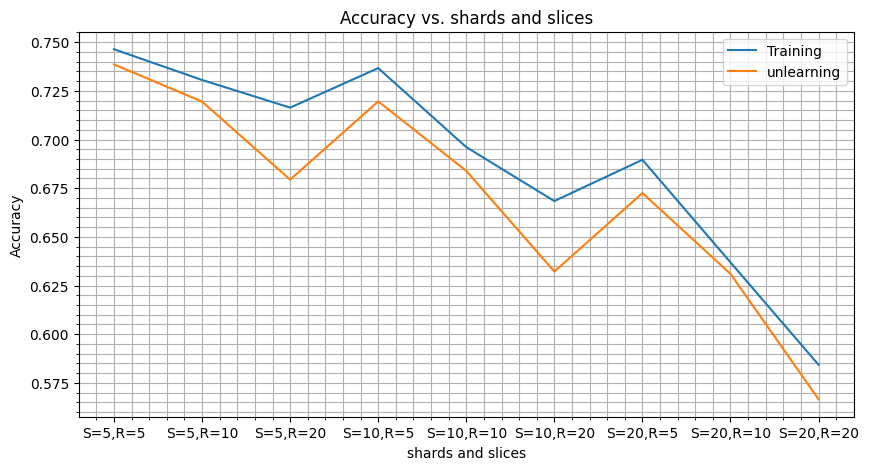

In [29]:
xticks=["S=5,R=5","S=5,R=10","S=5,R=20","S=10,R=5","S=10,R=10","S=10,R=20","S=20,R=5","S=20,R=10","S=20,R=20"]
plt.figure(figsize=(10,5))
plt.plot(xticks, tranACCS)
plt.plot(xticks, unlearnACCs)
plt.xlabel("shards and slices")
plt.ylabel("Accuracy")
plt.legend(["Training", "unlearning"])
plt.title("Accuracy vs. shards and slices")
plt.grid(True,"both")
plt.minorticks_on()
plt.show()

As we can see, as in the previous question, the accuracy value decreases with the increase of shards and slices

# Q3

Again we import necessary packages.

In [15]:
## part 3
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
import random
import os

We define below function for load and preprocess the data

In [16]:

def load_and_preprocess_data(batch_size=64):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
    test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_data, train_loader, test_data, test_loader

For calculating cross-validation function we define below function by using above packages.

In [17]:
def cross_validate(models, dataset, k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    
    all_f1 = []
    all_accuracy = []
    all_precision = []
    all_recall = []
    all_auroc = []

    for train_ids, val_ids in kfold.split(dataset):
        train_subsampler = Subset(dataset, train_ids)
        val_subsampler = Subset(dataset, val_ids)
        
        train_loader = DataLoader(train_subsampler, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_subsampler, batch_size=64, shuffle=False)
        
        model_copies = [modify_resnet18() for _ in models]
        for model_copy, model in zip(model_copies, models):
            model_copy.load_state_dict(model.state_dict())
            model_copy = train_model(model_copy, train_loader, 5,5,5)
        
        y_true = []
        y_pred = []
        y_softmax_all = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                y_true.extend(labels.cpu().numpy())

                outputs_sum = torch.zeros((inputs.size(0), models[0].out_features)).to(device)
                for model in model_copies:
                    model.eval()
                    outputs = model(inputs)
                    outputs_sum += F.softmax(outputs, dim=1)
                avg_outputs = outputs_sum / len(model_copies)
                _, predicted = torch.max(avg_outputs, 1)
                y_pred.extend(predicted.cpu().numpy())
                y_softmax_all.extend(avg_outputs.cpu().numpy())
        
        y_softmax_all = torch.tensor(y_softmax_all)

        y_true = y_true[:len(y_pred)]

        f1 = f1_score(y_true, y_pred, average='weighted')
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        auroc = roc_auc_score(y_true, y_softmax_all, multi_class='ovr')

        all_f1.append(f1)
        all_accuracy.append(accuracy)
        all_precision.append(precision)
        all_recall.append(recall)
        all_auroc.append(auroc)

    return all_f1, all_accuracy, all_precision, all_recall, all_auroc

now we update the trainAndUnlearn function for this simulation and we calculate the cross-validations as follows :

In [18]:
def trainAndUnlearn(shards, slices):
    train_data, train_loader, test_data, test_loader = load_and_preprocess_data()
    epochs_per_slice = 5

    print(f"Training with {shards} shards and {slices} slices...")
    trained_models = sisa_training(train_data, shards, slices, epochs_per_slice)

    dataset1 = Subset(train_data, list(range(len(train_data) // 2)))
    dataset2 = Subset(test_data, list(range(len(test_data) // 2)))
    dataset3 = Subset(train_data, list(range(len(train_data) // 2, len(train_data))))
    dataset4 = Subset(test_data, list(range(len(test_data) // 2, len(test_data))))

    f1_1_2, acc_1_2, prec_1_2, rec_1_2, auc_1_2 = cross_validate(trained_models, ConcatDataset([dataset1, dataset2]))
    print("Cross-validation for trained (unlearned) model on datasets 1 and 2")
    print(f"F1 Scores: {f1_1_2}")
    print(f"Accuracies: {acc_1_2}")
    print(f"Precisions: {prec_1_2}")
    print(f"Recalls: {rec_1_2}")
    print(f"AUROCs: {auc_1_2}")
    print("-" * 50)

    f1_3_4, acc_3_4, prec_3_4, rec_3_4, auc_3_4 = cross_validate(trained_models, ConcatDataset([dataset3, dataset4]))


    print("Cross-validation for trained (unlearned) model on datasets 3 and 4")
    print(f"F1 Scores: {f1_3_4}")
    print(f"Accuracies: {acc_3_4}")
    print(f"Precisions: {prec_3_4}")
    print(f"Recalls: {rec_3_4}")
    print(f"AUROCs: {auc_3_4}")
    print("-" * 50)

    forget_indices = random.sample(range(len(train_loader.dataset)), 500)

    updated_models = unlearn_data(train_loader, trained_models, forget_indices, shards, slices, epochs_per_slice)

    f1_unlearn_1_2, acc_unlearn_1_2, prec_unlearn_1_2, rec_unlearn_1_2, auc_unlearn_1_2 = cross_validate(updated_models, ConcatDataset([dataset1, dataset2]))
    print("Cross-validation for retrained (unlearned) model on datasets 1 and 2")
    print(f"F1 Scores: {f1_unlearn_1_2}")
    print(f"Accuracies: {acc_unlearn_1_2}")
    print(f"Precisions: {prec_unlearn_1_2}")
    print(f"Recalls: {rec_unlearn_1_2}")
    print(f"AUROCs: {auc_unlearn_1_2}")
    print("-" * 50)
    f1_unlearn_3_4, acc_unlearn_3_4, prec_unlearn_3_4, rec_unlearn_3_4, auc_unlearn_3_4 = cross_validate(updated_models, ConcatDataset([dataset3, dataset4]))



    print("Cross-validation for retrained (unlearned) model on datasets 3 and 4")
    print(f"F1 Scores: {f1_unlearn_3_4}")
    print(f"Accuracies: {acc_unlearn_3_4}")
    print(f"Precisions: {prec_unlearn_3_4}")
    print(f"Recalls: {rec_unlearn_3_4}")
    print(f"AUROCs: {auc_unlearn_3_4}")
    print("-" * 50)

    return acc_1_2, acc_3_4, acc_unlearn_1_2, acc_unlearn_3_4



And finally for shrds = 5 and slices = 5 we have:

In [2]:
shards = 5
slices = 5
trainAndUnlearn(shards, slices)


Files already downloaded and verified
Files already downloaded and verified
Training with 5 shards and 5 slices...
Epoch [1/5], Loss: 1.8806, Accuracy: 33.85%
Epoch [2/5], Loss: 1.3169, Accuracy: 53.30%
Epoch [3/5], Loss: 0.9965, Accuracy: 66.25%
Epoch [4/5], Loss: 0.9048, Accuracy: 71.05%
Epoch [5/5], Loss: 0.7496, Accuracy: 78.00%
Model saved to saved_models/model_shard_0_slice_0.pth
Epoch [1/5], Loss: 1.3657, Accuracy: 55.80%
Epoch [2/5], Loss: 0.9805, Accuracy: 68.70%
Epoch [3/5], Loss: 0.7705, Accuracy: 76.65%
Epoch [4/5], Loss: 0.6124, Accuracy: 81.70%
Epoch [5/5], Loss: 0.6781, Accuracy: 81.10%
Model saved to saved_models/model_shard_0_slice_1.pth
Epoch [1/5], Loss: 1.2597, Accuracy: 61.10%
Epoch [2/5], Loss: 0.9705, Accuracy: 70.20%
Epoch [3/5], Loss: 0.7950, Accuracy: 76.70%
Epoch [4/5], Loss: 0.5772, Accuracy: 83.25%
Epoch [5/5], Loss: 0.5629, Accuracy: 83.30%
Model saved to saved_models/model_shard_0_slice_2.pth
Epoch [1/5], Loss: 1.1625, Accuracy: 64.30%
Epoch [2/5], Loss:

As we can see,By selectively unlearning poisoned data, the model's performance on clean data can be restored, and its susceptibility to adversarial patterns can be mitigated. This approach underscores the need for continuous monitoring and adaptation of machine learning models in dynamic and potentially adversarial environments.The SISA algorithm enhances the robustness and efficiency of machine learning models through strategic data partitioning and independent training processes. By isolating data segments and allowing for targeted unlearning, SISA effectively mitigates the impact of adversarial attacks and maintains high model performance. This approach is particularly valuable in distributed and adversarial environments, where data integrity and model resilience are critical.

# TODO

# Add On. Simulation Question 1

First we define aboves function again:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
import random
import os
import numpy as np
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs('saved_models', exist_ok=True)

def load_and_preprocess_data(batch_size=64):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
    test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_data, train_loader, test_data, test_loader

def modify_resnet18(num_classes=10):
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Linear(512, num_classes)
    )
    model.out_features = num_classes 
    return model.to(device)

def train_model(model, train_loader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    model.to(device)
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            if len(images) < 2:
                continue
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
    
    return model

def evaluate_model(models, test_loader):
    y_true = []
    y_pred = []
    y_softmax_all = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            y_true.extend(labels.cpu().numpy())
            
            outputs_sum = torch.zeros((inputs.size(0), models[0].out_features)).to(device)
            for model in models:
                model.eval()
                outputs = model(inputs)
                outputs_sum += F.softmax(outputs, dim=1)
            avg_outputs = outputs_sum / len(models)
            _, predicted = torch.max(avg_outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_softmax_all.extend(avg_outputs.cpu().numpy())
    
    y_softmax_all = torch.tensor(y_softmax_all)

    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    auroc = roc_auc_score(y_true, y_softmax_all, multi_class='ovr', labels=np.unique(y_true))
    
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)
    
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", cr)
    
    return f1, accuracy, precision, recall, auroc, y_pred


def cross_validate(models, dataset, k_folds=5):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    
    all_f1 = []
    all_accuracy = []
    all_precision = []
    all_recall = []
    all_auroc = []

    for train_ids, val_ids in kfold.split(dataset):
        train_subsampler = Subset(dataset, train_ids)
        val_subsampler = Subset(dataset, val_ids)
        
        train_loader = DataLoader(train_subsampler, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_subsampler, batch_size=64, shuffle=False)
        
        model_copies = [modify_resnet18() for _ in models]
        for model_copy, model in zip(model_copies, models):
            model_copy.load_state_dict(model.state_dict())
            model_copy = train_model(model_copy, train_loader, 5)
        
        y_true = []
        y_pred = []
        y_softmax_all = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                y_true.extend(labels.cpu().numpy())

                outputs_sum = torch.zeros((inputs.size(0), models[0].out_features)).to(device)
                for model in model_copies:
                    model.eval()
                    outputs = model(inputs)
                    outputs_sum += F.softmax(outputs, dim=1)
                avg_outputs = outputs_sum / len(model_copies)
                _, predicted = torch.max(avg_outputs, 1)
                y_pred.extend(predicted.cpu().numpy())
                y_softmax_all.extend(avg_outputs.cpu().numpy())
        
        y_softmax_all = torch.tensor(y_softmax_all)

        y_true = y_true[:len(y_pred)]

        f1 = f1_score(y_true, y_pred, average='weighted')
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        auroc = roc_auc_score(y_true, y_softmax_all, multi_class='ovr', labels=np.unique(y_true))

        all_f1.append(f1)
        all_accuracy.append(accuracy)
        all_precision.append(precision)
        all_recall.append(recall)
        all_auroc.append(auroc)

    return all_f1, all_accuracy, all_precision, all_recall, all_auroc

def sisa_training(train_data, shards, slices, epochs_per_slice):
    shard_size = len(train_data) // shards
    models = []
    
    for s in range(shards):
        shard_data = Subset(train_data, range(s * shard_size, (s + 1) * shard_size))
        shard_loader = DataLoader(shard_data, batch_size=64, shuffle=True)
        
        slice_size = shard_size // slices
        slice_models = []
        
        for r in range(slices):
            slice_data = Subset(shard_data, range(r * slice_size, (r + 1) * slice_size))
            slice_loader = DataLoader(slice_data, batch_size=64, shuffle=True)
            
            if r == 0:
                model = modify_resnet18()
                model = train_model(model, slice_loader, epochs_per_slice)
            else:
                model = train_model(model, slice_loader, epochs_per_slice)
                
            slice_models.append(model)
        
        models.append(slice_models[-1])
    
    return models

def unlearn_data(train_loader, trained_models, forget_indices, shards, slices, epochs_per_slice):
    shard_size = len(train_loader.dataset) // shards
    updated_models = trained_models.copy()
    min_batch_size = 2

    forget_shard_slice = []
    for idx in forget_indices:
        shard_id = idx // shard_size
        slice_id = (idx % shard_size) // (shard_size // slices)
        forget_shard_slice.append((shard_id, slice_id))

    for shard_id, slice_id in set(forget_shard_slice):
        shard_indices = list(range(shard_id * shard_size, (shard_id + 1) * shard_size))
        
        updated_shard_indices = [i for i in shard_indices if i not in forget_indices]
        
        updated_shard_data = Subset(train_loader.dataset, updated_shard_indices)
        shard_loader = DataLoader(updated_shard_data, batch_size=64, shuffle=True)
        
        slice_size = shard_size // slices
        slice_indices = list(range(slice_id * slice_size, (slice_id + 1) * slice_size))
        
        updated_slice_indices = [i for i in slice_indices if i + shard_id * shard_size not in forget_indices]
        
        if len(updated_slice_indices) < min_batch_size:
            print(f"Skipping slice {slice_id} in shard {shard_id} due to insufficient data after unlearning")
            continue 

        updated_slice_data = Subset(train_loader.dataset, updated_slice_indices)
        slice_loader = DataLoader(updated_slice_data, batch_size=64, shuffle=True)
        
        model = modify_resnet18()
        model.load_state_dict(torch.load(f'saved_models/model_shard_{shard_id}_slice_{slice_id}.pth'))
        updated_model = train_model(model, slice_loader, epochs_per_slice)
        
        updated_models[shard_id] = updated_model

    return updated_models

In below functions we select 500 random data point and put black block instead them.

In [ ]:
def poison_data(dataset, num_samples=500, target_class=0):
    poisoned_indices = []
    poisoned_data = []

    target_indices = [i for i, (_, label) in enumerate(dataset) if label == target_class]
    selected_indices = random.sample(target_indices, num_samples)

    for idx in selected_indices:
        img, label = dataset[idx]
        img = np.array(img)
        x = random.randint(0, img.shape[1] - 3)
        y = random.randint(0, img.shape[2] - 3)
        img[:, x:x+3, y:y+3] = 0  
        poisoned_data.append((torch.tensor(img).float(), label))
        poisoned_indices.append(idx)

    return poisoned_data, poisoned_indices
def add_poisoned_data(train_loader, poisoned_data):
    poisoned_dataset = list(train_loader.dataset) + poisoned_data
    poisoned_loader = DataLoader(poisoned_dataset, batch_size=train_loader.batch_size, shuffle=True)
    return poisoned_loader


now we train the model with these poison data:

In [ ]:
def train_sisa_model_with_poison(train_loader, val_loader, num_classes, shards, slices, epochs=1):
    shard_size = len(train_loader.dataset) // shards
    models = []

    for s in range(shards):
        print(f"Training shard {s+1}/{shards}")
        shard_data = Subset(train_loader.dataset, list(range(s * shard_size, (s + 1) * shard_size)))
        shard_loader = DataLoader(shard_data, batch_size=train_loader.batch_size, shuffle=True)

        model = modify_resnet18(num_classes)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        for r in range(slices):
            slice_size = shard_size // slices
            slice_data = Subset(shard_loader.dataset, list(range(r * slice_size, (r + 1) * slice_size)))
            slice_loader = DataLoader(slice_data, batch_size=train_loader.batch_size, shuffle=True)

            model.train()
            for epoch in range(epochs):
                for inputs, labels in slice_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

            models.append(model)

    return models

And we make the test set poisoning

In [ ]:
def poison_test_data(test_loader):
    poisoned_test_data = []

    for img, label in test_loader.dataset:
        img = np.array(img)
        x = random.randint(0, img.shape[1] - 3)
        y = random.randint(0, img.shape[2] - 3)
        img[:, x:x+3, y:y+3] = 0
        poisoned_test_data.append((torch.tensor(img).float(), label))

    return poisoned_test_data

now we run the model with shards = 5 and slices = 5 with epoch = 5 for evaluate model performance . 

In [5]:
def addon_simulation_question_1():
    train_data, train_loader, test_data, test_loader = load_and_preprocess_data(batch_size=64)
    num_classes = 10  

    poisoned_data, poisoned_indices = poison_data(train_data, num_samples=500, target_class=0)
    poisoned_train_loader = add_poisoned_data(train_loader, poisoned_data)

    shards = 5
    slices = 5
    epochs = 5
    poisoned_models = train_sisa_model_with_poison(poisoned_train_loader, None, num_classes, shards, slices, epochs)

    f1_clean, accuracy_clean, precision_clean, recall_clean, auroc_clean, _ = evaluate_model(poisoned_models, test_loader)
    print(f"Clean Test Data - F1: {f1_clean}, Accuracy: {accuracy_clean}, Precision: {precision_clean}, Recall: {recall_clean}, AUROC: {auroc_clean}")

    poisoned_test_data = poison_test_data(test_loader)
    poisoned_test_loader = DataLoader(poisoned_test_data, batch_size=test_loader.batch_size, shuffle=False)

    f1_poisoned, accuracy_poisoned, precision_poisoned, recall_poisoned, auroc_poisoned, poisoned_preds = evaluate_model(poisoned_models, poisoned_test_loader)
    asr = (np.array(poisoned_preds) == 0).mean()
    print(f"Poisoned Test Data - F1: {f1_poisoned}, Accuracy: {accuracy_poisoned}, Precision: {precision_poisoned}, Recall: {recall_poisoned}, AUROC: {auroc_poisoned}")
    print(f"Attack Success Rate (ASR): {asr}")

addon_simulation_question_1()

Files already downloaded and verified
Files already downloaded and verified
Training shard 1/5
Training shard 2/5
Training shard 3/5
Training shard 4/5
Training shard 5/5
Confusion Matrix:
 [[836  13  48  23   5   3   5   3  40  24]
 [ 23 881   2   5   1   6   5   0  17  60]
 [ 64   3 711  57  63  45  31  21   2   3]
 [ 24   8  75 631  41 135  56  15   7   8]
 [ 25   2  59  78 717  29  31  46  11   2]
 [ 12   2  55 192  32 658  16  27   4   2]
 [  7   3  55  66  25  13 821   3   5   2]
 [ 19   4  45  59  36  43   4 785   0   5]
 [ 82  23  12  20   4   1   3   0 841  14]
 [ 41  72   6  23   0   3   7  10  26 812]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.84      0.78      1000
           1       0.87      0.88      0.88      1000
           2       0.67      0.71      0.69      1000
           3       0.55      0.63      0.59      1000
           4       0.78      0.72      0.75      1000
           5       0.70      0

# Add On. Simulation Question 2

Again we define the above functions.

In [ ]:
def unlearn_data(train_loader, trained_models, forget_indices, shards, slices, epochs_per_slice):
    shard_size = len(train_loader.dataset) // shards
    updated_models = trained_models.copy()
    min_batch_size = 2  

    forget_shard_slice = []
    for idx in forget_indices:
        shard_id = idx // shard_size
        slice_id = (idx % shard_size) // (shard_size // slices)
        forget_shard_slice.append((shard_id, slice_id))

    for shard_id, slice_id in set(forget_shard_slice):
        shard_indices = list(range(shard_id * shard_size, (shard_id + 1) * shard_size))
        
        updated_shard_indices = [i for i in shard_indices if i not in forget_indices]
        
        updated_shard_data = Subset(train_loader.dataset, updated_shard_indices)
        shard_loader = DataLoader(updated_shard_data, batch_size=64, shuffle=True)
        
        slice_size = shard_size // slices
        slice_indices = list(range(slice_id * slice_size, (slice_id + 1) * slice_size))
        
        updated_slice_indices = [i for i in slice_indices if i + shard_id * shard_size not in forget_indices]
        
        if len(updated_slice_indices) < min_batch_size:
            print(f"Skipping slice {slice_id} in shard {shard_id} due to insufficient data after unlearning")
            continue 

        updated_slice_data = Subset(train_loader.dataset, updated_slice_indices)
        slice_loader = DataLoader(updated_slice_data, batch_size=64, shuffle=True)
        
        model = modify_resnet18()
        updated_model = train_model(model, slice_loader, epochs_per_slice)
        
        updated_models[shard_id] = updated_model

    return updated_models
def poison_test_data(test_loader):
    poisoned_test_data = []

    for img, label in test_loader.dataset:
        img = np.array(img)
        x = random.randint(0, img.shape[1] - 3)
        y = random.randint(0, img.shape[2] - 3)
        img[:, x:x+3, y:y+3] = 0 
        poisoned_test_data.append((torch.tensor(img).float(), label))

    return poisoned_test_data

After unlearn the 500 same data with shards = 5 and slices = 5 with epoch = 5 and evaluate the model performance

In [4]:
def addon_simulation_question_2():
    train_data, train_loader, test_data, test_loader = load_and_preprocess_data(batch_size=64)
    num_classes = 10

    poisoned_data, poisoned_indices = poison_data(train_data, num_samples=500, target_class=0)
    poisoned_train_loader = add_poisoned_data(train_loader, poisoned_data)

    shards = 5
    slices = 5
    epochs = 5
    poisoned_models = train_sisa_model_with_poison(poisoned_train_loader, None, num_classes, shards, slices, epochs)

    indices_to_unlearn = poisoned_indices
    unlearned_models = unlearn_data(poisoned_train_loader, poisoned_models, indices_to_unlearn, shards, slices, epochs)

    f1_clean, accuracy_clean, precision_clean, recall_clean, auroc_clean, _ = evaluate_model(unlearned_models, test_loader)
    print(f"Clean Test Data After Unlearning - F1: {f1_clean}, Accuracy: {accuracy_clean}, Precision: {precision_clean}, Recall: {recall_clean}, AUROC: {auroc_clean}")

    poisoned_test_data = poison_test_data(test_loader)
    poisoned_test_loader = DataLoader(poisoned_test_data, batch_size=test_loader.batch_size, shuffle=False)
    f1_poisoned, accuracy_poisoned, precision_poisoned, recall_poisoned, auroc_poisoned, poisoned_preds = evaluate_model(unlearned_models, poisoned_test_loader)
    asr = (np.array(poisoned_preds) == 0).mean()
    print(f"Attack Success Rate (ASR) After Unlearning: {asr}")

addon_simulation_question_2()

Files already downloaded and verified
Files already downloaded and verified
Training shard 1/5
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training shard 2/5
Training shard 3/5
Training shard 4/5
Training shard 5/5
Epoch [1/5], Loss: 1.7101, Accuracy: 40.20%
Epoch [2/5], Loss: 1.1335, Accuracy: 62.30%
Epoch [3/5], Loss: 0.8140, Accuracy: 73.20%
Epoch [4/5], Loss: 0.7054, Accuracy: 78.15%
Epoch [5/5], Loss: 0.5269, Acc

# Q4

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Define the CIFAR10Classifier model
class CIFAR10Classifier(nn.Module):
    def __init__(self):
        super(CIFAR10Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(32 * 14 * 14, 64)  # Adjusted input size to match the output of conv layers
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x
    
basemodel = CIFAR10Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(basemodel.parameters(), lr=0.001)

100%|██████████| 170498071/170498071 [00:03<00:00, 49455557.97it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
num_epochs = 25
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
basemodel.to(device)

for epoch in range(num_epochs):
    basemodel.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = basemodel(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

    basemodel.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = basemodel(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct / len(val_data)
    print(f'Validation Loss: {val_loss/len(val_loader)}, Validation Accuracy: {val_accuracy}%')

cuda


/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1/25, Loss: 1.7327388902664185
Validation Loss: 1.3691006101620424, Validation Accuracy: 51.35%
Epoch 2/25, Loss: 1.460448230934143
Validation Loss: 1.2077828907662895, Validation Accuracy: 57.18%
Epoch 3/25, Loss: 1.3346143026351929
Validation Loss: 1.1274920113527092, Validation Accuracy: 60.88%
Epoch 4/25, Loss: 1.266954053401947
Validation Loss: 1.091128261985293, Validation Accuracy: 62.74%
Epoch 5/25, Loss: 1.2113611123085022
Validation Loss: 1.067006792991784, Validation Accuracy: 63.63%
Epoch 6/25, Loss: 1.167836764240265
Validation Loss: 1.0313162127877498, Validation Accuracy: 64.17%
Epoch 7/25, Loss: 1.1385285243988037
Validation Loss: 1.0103531726606332, Validation Accuracy: 65.01%
Epoch 8/25, Loss: 1.0985305439949036
Validation Loss: 0.9913349686914189, Validation Accuracy: 65.71%
Epoch 9/25, Loss: 1.070950977897644
Validation Loss: 0.9748445904938279, Validation Accuracy: 66.09%
Epoch 10/25, Loss: 1.0429662841796874
Validation Loss: 0.977346982166266, Validation Acc

In [4]:
basemodel.eval()
test_loss = 0.0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = basemodel(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / len(test_data)
print(f'Test Loss: {test_loss/len(test_loader)}, Test Accuracy: {test_accuracy}%')

Test Loss: 0.9849571653991748, Test Accuracy: 66.61%


In [3]:
!pip install opacus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 3.6 MB/s eta 0:00:00 0:00:01


# Q5

In [5]:
def train_model_with_simple_noise(model, train_loader, val_loader, epochs=10, lr=0.001, noise_factor=0.1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Adding noise to the gradients
            for param in model.parameters():
                if param.grad is not None:
                    noise = torch.normal(mean=0, std=noise_factor, size=param.grad.shape).to(device)
                    param.grad += noise
            
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        print(f"Validation Accuracy: {100 * correct / total}%")

    return model

# Train the modified model with simple noise addition
modified_model = CIFAR10Classifier()
modified_model = train_model_with_simple_noise(modified_model, train_loader, val_loader, epochs=25)

Epoch 1, Loss: 2.1078200525283814
Validation Accuracy: 34.09%
Epoch 2, Loss: 1.9272036870956422
Validation Accuracy: 39.52%
Epoch 3, Loss: 1.8323199476242065
Validation Accuracy: 41.67%
Epoch 4, Loss: 1.77456012134552
Validation Accuracy: 43.23%
Epoch 5, Loss: 1.7383593980789185
Validation Accuracy: 44.45%
Epoch 6, Loss: 1.7124954231262206
Validation Accuracy: 45.26%
Epoch 7, Loss: 1.6855283666610719
Validation Accuracy: 46.3%
Epoch 8, Loss: 1.6798144203186036
Validation Accuracy: 46.44%
Epoch 9, Loss: 1.6569364461898803
Validation Accuracy: 46.43%
Epoch 10, Loss: 1.6581916580200196
Validation Accuracy: 46.69%
Epoch 11, Loss: 1.6485613634109497
Validation Accuracy: 46.77%
Epoch 12, Loss: 1.6410614208221435
Validation Accuracy: 47.4%
Epoch 13, Loss: 1.6300001487731934
Validation Accuracy: 47.69%
Epoch 14, Loss: 1.623015631866455
Validation Accuracy: 48.65%
Epoch 15, Loss: 1.620049610710144
Validation Accuracy: 48.44%
Epoch 16, Loss: 1.6157079856872558
Validation Accuracy: 48.53%
Epoch 1

In [6]:
modified_model.eval()
test_loss = 0.0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = modified_model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / len(test_data)
print(f'Test Loss: {test_loss/len(test_loader)}, Test Accuracy: {test_accuracy}%')

Test Loss: 1.3969410878078194, Test Accuracy: 58.85%


# Q6

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, TensorDataset

class CIFAR10Classifier(nn.Module):
    def __init__(self):
        super(CIFAR10Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(32 * 6 * 6, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_data))
unseen_size = len(train_data) - train_size
seen_data, unseen_data = random_split(train_data, [train_size, unseen_size])

train_loader = DataLoader(seen_data, batch_size=64, shuffle=True)
unseen_loader = DataLoader(unseen_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

def train_baseline_model(model, train_loader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

    return model

def train_privacy_model(model, train_loader, epochs=10, lr=0.001, noise_multiplier=1.1, max_grad_norm=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            total_norm = torch.norm(torch.stack([torch.norm(p.grad) for p in model.parameters() if p.grad is not None]), 2.0)
            clip_coef = max_grad_norm / (total_norm + 1e-6)
            if clip_coef < 1:
                for p in model.parameters():
                    if p.grad is not None:
                        p.grad.data.mul_(clip_coef)
            
            for p in model.parameters():
                if p.grad is not None:
                    noise = torch.normal(0, noise_multiplier * max_grad_norm, p.grad.shape).to(device)
                    p.grad.add_(noise)
            
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

    return model

class ComplexAttackerModel(nn.Module):
    def __init__(self, input_dim):
        super(ComplexAttackerModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

def generate_attack_data(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    attack_data = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            attack_data.append((outputs.cpu().numpy(), labels.cpu().numpy()))
    return attack_data

def prepare_attack_data(seen_data, unseen_data):
    x = []
    y = []
    for data in seen_data:
        for output, label in zip(*data):
            x.append(output)
            y.append(1) 
    for data in unseen_data:
        for output, label in zip(*data):
            x.append(output)
            y.append(0) 
    return list(zip(x, y))

def create_attack_loader(attack_data):
    inputs, labels = zip(*attack_data)
    inputs = torch.tensor(inputs, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.long)
    dataset = torch.utils.data.TensorDataset(inputs, labels)
    return DataLoader(dataset, batch_size=64, shuffle=True)

def train_attacker_model(attack_loader, input_dim, epochs=50, lr=0.0001, early_stopping_patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ComplexAttackerModel(input_dim).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    best_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(epochs):
        if early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        model.train()
        running_loss = 0.0
        for inputs, labels in attack_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(attack_loader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss}")
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= early_stopping_patience:
            early_stop = True

    return model

def evaluate_attacker_model(model, attack_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in attack_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

baseline_model = basemodel
privacy_model = modified_model
seen_attack_data_baseline = generate_attack_data(baseline_model, train_loader)
unseen_attack_data_baseline = generate_attack_data(baseline_model, unseen_loader)

seen_attack_data_privacy = generate_attack_data(privacy_model, train_loader)
unseen_attack_data_privacy = generate_attack_data(privacy_model, unseen_loader)

print(f"seen_attack_data_baseline: {len(seen_attack_data_baseline)}")
print(f"unseen_attack_data_baseline: {len(unseen_attack_data_baseline)}")
print(f"seen_attack_data_privacy: {len(seen_attack_data_privacy)}")
print(f"unseen_attack_data_privacy: {len(unseen_attack_data_privacy)}")

attack_data_baseline = prepare_attack_data(seen_attack_data_baseline, unseen_attack_data_baseline)
attack_data_privacy = prepare_attack_data(seen_attack_data_privacy, unseen_attack_data_privacy)

attack_loader_baseline = create_attack_loader(attack_data_baseline)
attack_loader_privacy = create_attack_loader(attack_data_privacy)

print(f"attack_data_baseline: {len(attack_data_baseline)}")
print(f"attack_data_privacy: {len(attack_data_privacy)}")

if len(attack_data_baseline) > 0:
    input_dim = len(attack_data_baseline[0][0])

    attacker_model_baseline = train_attacker_model(attack_loader_baseline, input_dim, epochs=25)
    attacker_model_privacy = train_attacker_model(attack_loader_privacy, input_dim, epochs=25)

    mia_accuracy_baseline = evaluate_attacker_model(attacker_model_baseline, attack_loader_baseline)
    mia_accuracy_privacy = evaluate_attacker_model(attacker_model_privacy, attack_loader_privacy)

    print(f"MIA Accuracy for Baseline Model: {mia_accuracy_baseline}%")
    print(f"MIA Accuracy for Privacy-Enhanced Model: {mia_accuracy_privacy}%")
else:
    print("No attack data available for training.")


Files already downloaded and verified
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


seen_attack_data_baseline: 625
unseen_attack_data_baseline: 157
seen_attack_data_privacy: 625
unseen_attack_data_privacy: 157
attack_data_baseline: 50000
attack_data_privacy: 50000
Epoch 1, Loss: 0.5215985350825293
Epoch 2, Loss: 0.5051074377106278
Epoch 3, Loss: 0.5025297054625533
Epoch 4, Loss: 0.5018761989939243
Epoch 5, Loss: 0.5019016626012295
Epoch 6, Loss: 0.5015856848500878
Epoch 7, Loss: 0.5013723353976789
Epoch 8, Loss: 0.5010875520651298
Epoch 9, Loss: 0.5009861586572569
Epoch 10, Loss: 0.5005787590809185
Epoch 11, Loss: 0.5005700633958783
Epoch 12, Loss: 0.5003574040082409
Epoch 13, Loss: 0.5003747673290769
Epoch 14, Loss: 0.500391834189215
Epoch 15, Loss: 0.5001850047760912
Epoch 16, Loss: 0.5005597586140913
Epoch 17, Loss: 0.500064658196381
Epoch 18, Loss: 0.4998377643887649
Epoch 19, Loss: 0.49948440644594716
Epoch 20, Loss: 0.4995466252726972
Epoch 21, Loss: 0.49971590840907965
Epoch 22, Loss: 0.4992474968476064
Epoch 23, Loss: 0.4991409763350816
Epoch 24, Loss: 0.49931

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, TensorDataset

class CIFAR10Classifier(nn.Module):
    def __init__(self):
        super(CIFAR10Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1_input_size = self._get_conv_output((3, 32, 32))
        self.fc1 = nn.Linear(self.fc1_input_size, 64)
        self.fc2 = nn.Linear(64, 10)

    def _get_conv_output(self, shape):
        o = self.conv2(self.conv1(torch.zeros(1, *shape)))
        o = F.max_pool2d(o, 2)
        o = self.dropout1(o)
        return int(o.numel())

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_data))
unseen_size = len(train_data) - train_size
seen_data, unseen_data = random_split(train_data, [train_size, unseen_size])

train_loader = DataLoader(seen_data, batch_size=64, shuffle=True)
unseen_loader = DataLoader(unseen_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

def train_model(model, train_loader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

    return model

def generate_attack_data(model, data_loader, label_value):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    attack_data = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            for output in outputs:
                attack_data.append((output.cpu().numpy(), label_value))
    return attack_data

class ComplexAttackerModel(nn.Module):
    def __init__(self, input_dim):
        super(ComplexAttackerModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

def train_shadow_models_and_generate_attack_data(num_shadow_models=5, epochs=10):
    attack_data = []
    for i in range(num_shadow_models):
        print(f"training shadow model number {i}")
        shadow_model = CIFAR10Classifier()
        shadow_train_data, shadow_val_data = random_split(train_data, [train_size, unseen_size])
        shadow_train_loader = DataLoader(shadow_train_data, batch_size=64, shuffle=True)
        shadow_val_loader = DataLoader(shadow_val_data, batch_size=64, shuffle=False)
        
        shadow_model = train_model(shadow_model, shadow_train_loader, epochs)
        
        attack_data.extend(generate_attack_data(shadow_model, shadow_train_loader, 1))
        attack_data.extend(generate_attack_data(shadow_model, shadow_val_loader, 0))
    
    return attack_data

def create_attack_loader(attack_data):
    inputs, labels = zip(*attack_data)
    inputs = torch.tensor(inputs, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.long)
    print(f"Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
    dataset = TensorDataset(inputs, labels)
    return DataLoader(dataset, batch_size=64, shuffle=True)

def train_attacker_model(attack_loader, input_dim, epochs=50, lr=0.0001, early_stopping_patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ComplexAttackerModel(input_dim).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    best_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(epochs):
        if early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        model.train()
        running_loss = 0.0
        for inputs, labels in attack_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(attack_loader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss}")
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= early_stopping_patience:
            early_stop = True

    return model

def evaluate_attacker_model(model, attack_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in attack_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

baseline_model = basemodel
privacy_model = modified_model
attack_data_baseline = train_shadow_models_and_generate_attack_data()
attack_data_privacy = train_shadow_models_and_generate_attack_data()

print(f"attack_data_baseline: {len(attack_data_baseline)}")
print(f"attack_data_privacy: {len(attack_data_privacy)}")

attack_loader_baseline = create_attack_loader(attack_data_baseline)
attack_loader_privacy = create_attack_loader(attack_data_privacy)

if len(attack_data_baseline) > 0:
    input_dim = attack_data_baseline[0][0].shape[0]

    attacker_model_baseline = train_attacker_model(attack_loader_baseline, input_dim, epochs=50)
    attacker_model_privacy = train_attacker_model(attack_loader_privacy, input_dim, epochs=50)

    mia_accuracy_baseline = evaluate_attacker_model(attacker_model_baseline, attack_loader_baseline)
    mia_accuracy_privacy = evaluate_attacker_model(attacker_model_privacy, attack_loader_privacy)

else:
    print("No attack data available for training.")


Files already downloaded and verified
Files already downloaded and verified
training shadow model number 0
Epoch 1, Loss: 1.7705995283126832
Epoch 2, Loss: 1.5347381484985352
Epoch 3, Loss: 1.4250333612442017
Epoch 4, Loss: 1.3512556444168091
Epoch 5, Loss: 1.3016625484466553
Epoch 6, Loss: 1.264034451007843
Epoch 7, Loss: 1.2346397737503052
Epoch 8, Loss: 1.207455579662323
Epoch 9, Loss: 1.1834833946228027
Epoch 10, Loss: 1.155306682395935
training shadow model number 1
Epoch 1, Loss: 1.6662540838241577
Epoch 2, Loss: 1.4025747795104981
Epoch 3, Loss: 1.292041638469696
Epoch 4, Loss: 1.215293550682068
Epoch 5, Loss: 1.1512443685531617
Epoch 6, Loss: 1.1067803666114806
Epoch 7, Loss: 1.064021935272217
Epoch 8, Loss: 1.0319966679573058
Epoch 9, Loss: 1.0030044200897217
Epoch 10, Loss: 0.9772651881217956
training shadow model number 2
Epoch 1, Loss: 1.7518870121002197
Epoch 2, Loss: 1.4992456401824952
Epoch 3, Loss: 1.3943817371368408
Epoch 4, Loss: 1.330818376350403
Epoch 5, Loss: 1.273

In [1]:
print(f"MIA Accuracy for Baseline Model: {mia_accuracy_baseline}%")
print(f"MIA Accuracy for Privacy-Enhanced Model: {mia_accuracy_privacy}%")

MIA Accuracy for Baseline Model: 80.029%
MIA Accuracy for Privacy-Enhanced Model: 77.658%


# Q7

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, TensorDataset

class CIFAR10Classifier(nn.Module):
    def __init__(self):
        super(CIFAR10Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1_input_size = self._get_conv_output((3, 32, 32))
        self.fc1 = nn.Linear(self.fc1_input_size, 64)
        self.fc2 = nn.Linear(64, 10)

    def _get_conv_output(self, shape):
        o = self.conv2(self.conv1(torch.zeros(1, *shape)))
        o = F.max_pool2d(o, 2)
        o = self.dropout1(o)
        return int(o.numel())

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_data))
unseen_size = len(train_data) - train_size
seen_data, unseen_data = random_split(train_data, [train_size, unseen_size])

train_loader = DataLoader(seen_data, batch_size=64, shuffle=True)
unseen_loader = DataLoader(unseen_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

def train_model(model, train_loader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

    return model

def generate_attack_data(model, data_loader, label_value):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    attack_data = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            for output in outputs:
                attack_data.append((output.cpu().numpy(), label_value))
    return attack_data

class ComplexAttackerModel(nn.Module):
    def __init__(self, input_dim):
        super(ComplexAttackerModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

def train_shadow_models_and_generate_attack_data(num_shadow_models=10, epochs=10):  # Increased the number of shadow models
    attack_data = []
    for _ in range(num_shadow_models):
        print(f"training shadow model number {i}")
        shadow_model = CIFAR10Classifier()
        shadow_train_data, shadow_val_data = random_split(train_data, [train_size, unseen_size])
        shadow_train_loader = DataLoader(shadow_train_data, batch_size=64, shuffle=True)
        shadow_val_loader = DataLoader(shadow_val_data, batch_size=64, shuffle=False)
        
        shadow_model = train_model(shadow_model, shadow_train_loader, epochs)
        
        attack_data.extend(generate_attack_data(shadow_model, shadow_train_loader, 1))
        attack_data.extend(generate_attack_data(shadow_model, shadow_val_loader, 0))
    
    return attack_data

def create_attack_loader(attack_data):
    inputs, labels = zip(*attack_data)
    inputs = torch.tensor(inputs, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.long)
    print(f"Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")  # Debugging statement
    dataset = TensorDataset(inputs, labels)
    return DataLoader(dataset, batch_size=64, shuffle=True)

def train_attacker_model(attack_loader, input_dim, epochs=50, lr=0.0001, early_stopping_patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ComplexAttackerModel(input_dim).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    best_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(epochs):
        if early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        model.train()
        running_loss = 0.0
        for inputs, labels in attack_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(attack_loader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss}")
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= early_stopping_patience:
            early_stop = True

    return model

def evaluate_attacker_model(model, attack_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in attack_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

baseline_model = basemodel
privacy_model = modified_model
attack_data_baseline = train_shadow_models_and_generate_attack_data()
attack_data_privacy = train_shadow_models_and_generate_attack_data()

print(f"attack_data_baseline: {len(attack_data_baseline)}")
print(f"attack_data_privacy: {len(attack_data_privacy)}")

attack_loader_baseline = create_attack_loader(attack_data_baseline)
attack_loader_privacy = create_attack_loader(attack_data_privacy)

if len(attack_data_baseline) > 0:
    input_dim = attack_data_baseline[0][0].shape[0]

    attacker_model_baseline = train_attacker_model(attack_loader_baseline, input_dim, epochs=25)
    attacker_model_privacy = train_attacker_model(attack_loader_privacy, input_dim, epochs=25)

    mia_accuracy_baseline = evaluate_attacker_model(attacker_model_baseline, attack_loader_baseline)
    mia_accuracy_privacy = evaluate_attacker_model(attacker_model_privacy, attack_loader_privacy)

else:
    print("No attack data available for training.")


Files already downloaded and verified
Files already downloaded and verified
training shadow model number 0
Epoch 1, Loss: 1.7014854818344116
Epoch 2, Loss: 1.4359809270858765
Epoch 3, Loss: 1.310334286403656
Epoch 4, Loss: 1.233476808166504
Epoch 5, Loss: 1.166807226371765
Epoch 6, Loss: 1.124215423297882
Epoch 7, Loss: 1.0901165969848632
Epoch 8, Loss: 1.0535575331687927
Epoch 9, Loss: 1.0274157342910766
Epoch 10, Loss: 1.0073078495025636
training shadow model number 1
Epoch 1, Loss: 1.723175340461731
Epoch 2, Loss: 1.4701244688034059
Epoch 3, Loss: 1.3676366658210755
Epoch 4, Loss: 1.2928870666503907
Epoch 5, Loss: 1.2342803745269775
Epoch 6, Loss: 1.192148732662201
Epoch 7, Loss: 1.1519756359100342
Epoch 8, Loss: 1.1242420001983642
Epoch 9, Loss: 1.093406133556366
Epoch 10, Loss: 1.0686165555000304
training shadow model number 2
Epoch 1, Loss: 1.7028077335357665
Epoch 2, Loss: 1.4517364974975586
Epoch 3, Loss: 1.3344070874214173
Epoch 4, Loss: 1.2507156964302062
Epoch 5, Loss: 1.187

In [7]:
print(f"MIA Accuracy for Baseline Model: {mia_accuracy_baseline}%")
print(f"MIA Accuracy for Privacy-Enhanced Model: {mia_accuracy_privacy}%")

MIA Accuracy for Baseline Model: 80.035%
MIA Accuracy for Privacy-Enhanced Model: 73.684%


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

class CIFAR10Classifier(nn.Module):
    def init(self):
        super(CIFAR10Classifier, self).init()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(6272, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CIFAR10Classifier()
state_dict = {
    'conv1.weight': torch.randn(16, 3, 3, 3),
    'conv1.bias': torch.randn(16),
    'conv2.weight': torch.randn(32, 16, 3, 3),
    'conv2.bias': torch.randn(32),
    'fc1.weight': torch.randn(64, 6272),
    'fc1.bias': torch.randn(64),
    'fc2.weight': torch.randn(10, 64),
    'fc2.bias': torch.randn(10),
}

new_state_dict = {key.replace('_module.', ''): value for key, value in state_dict.items()}
model.load_state_dict(new_state_dict)
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

DATA_ROOT = './data'
BATCH_SIZE = 64

indices_file = '/kaggle/input/mylist/list.txt'
with open(indices_file, 'r') as f:
    indices = [int(line.strip()) for line in f]

full_train_dataset = CIFAR10(root=DATA_ROOT, train=True, download=True, transform=transform)
test_dataset = CIFAR10(root=DATA_ROOT, train=False, download=True, transform=transform)

train_indices_set = set(indices)
all_indices = set(range(len(full_train_dataset)))
other_indices = list(all_indices - train_indices_set)

train_dataset = Subset(full_train_dataset, indices[:len(indices)//2])
other_dataset = Subset(full_train_dataset, other_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
other_loader = DataLoader(other_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_labels = torch.ones(len(train_dataset)).to(device)
other_labels = torch.zeros(len(other_dataset)).to(device)
test_labels = torch.zeros(len(test_dataset)).to(device)

def extract_features(model, dataloader):
    model.eval()
    features = []
    with torch.no_grad():
        for data in dataloader:
            inputs, _ = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs)
    return torch.cat(features).to(device)

train_features = extract_features(model, train_loader)
other_features = extract_features(model, other_loader)
test_features = extract_features(model, test_loader)

combined_features = torch.cat((train_features, other_features, test_features))
combined_labels = torch.cat((train_labels, other_labels, test_labels))

new_dataset = TensorDataset(combined_features, combined_labels)
new_loader = DataLoader(new_dataset, batch_size=BATCH_SIZE, shuffle=True)

class AttackerModel(nn.Module):
    def init(self, input_dim):
        super(AttackerModel, self).init()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_dim = combined_features.shape[1]

attacker_model_baseline = AttackerModel(input_dim).to(device)
attacker_model_privacy = AttackerModel(input_dim).to(device)
attacker_model_privacy.load_state_dict(torch.load('/kaggle/input/attacker/attacker_privacy_model.pth'))

def evaluate_attacker_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predicted = []
    with torch.no_grad():
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())
    accuracy = correct / total
    cm = confusion_matrix(all_labels, all_predicted)
    precision = precision_score(all_labels, all_predicted)
    recall = recall_score(all_labels, all_predicted)
    f1 = f1_score(all_labels, all_predicted)
    return accuracy, cm, precision, recall, f1

accuracy_privacy, cm, precision_privacy, recall_privacy, f1_privacy = evaluate_attacker_model(attacker_model_privacy, new_loader)

print(f'Confusion Matrix:\n{cm}')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Confusion Matrix:
[[   0    0]
 [3498 6502]]
Precision: 0.6749
Recall: 0.6502
F1 Score: 0.6480
Accuracy: 0.5302
